## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
#!pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost==2.0.3 threadpoolctl==3.3.0 -q --user

**Note:** After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# For imputing missing values
from sklearn.impute import SimpleImputer 

# To get different metric scores
from sklearn import metrics

# To split data, create K folds, get cross validation scores, and create grid searches
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score)

# To build logistic regression models
from sklearn.linear_model import LogisticRegression

# To build decision tree models
from sklearn.tree import DecisionTreeClassifier

# To build ensemble models
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier, 
    AdaBoostClassifier, GradientBoostingClassifier,
    StackingClassifier)

# To build XGBoost models
from xgboost import XfGBClassifier

# To undersample and oversample the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To create a pipeline
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline 


## Loading the dataset

In [3]:
# Load the training csv file
def csv_read(file):
    """
    Reads a CSV file sample to quickly determine the data types and then 
    load the full file quicker
    
    file: the name of the csv to load    
    """
    # Read the first 20 rows
    df_sample = pd.read_csv(file, nrows=20)
    dt={}
    
    # Determine the datatypes of the columns from the sample data
    for col, dtyp in zip(df_sample.columns, df_sample.dtypes):
        dt[col] = dtyp
    
    # Load the entire main file using the datatypes determined in the sample load
    df_final = pd.read_csv(file, dtype = dt)
    return df_final
    
# Call the csv_read function to load the train and test files
df = csv_read('Train.csv')
df_test = csv_read('Test.csv')

## Data Overview

- Observations
- Sanity checks

In [4]:
# Display the first 5 rows of training data
df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -4.464606 -4.679129  3.101546  0.506130 -0.221083 -2.032511 -2.910870   
1  3.365912  3.653381  0.909671 -1.367528  0.332016  2.358938  0.732600   
2 -3.831843 -5.824444  0.634031 -2.418815 -1.773827  1.016824 -2.098941   
3  1.618098  1.888342  7.046143 -1.147285  0.083080 -1.529780  0.207309   
4 -0.111440  3.872488 -3.758361 -2.982897  3.792714  0.544960  0.205433   

         V8        V9       V10  ...       V32       V33        V34       V35  \
0  0.050714 -1.522351  3.761892  ...  3.059700 -1.690440   2.846296  2.235198   
1 -4.332135  0.565695 -0.101080  ... -1.795474  3.032780  -2.467514  1.894599   
2 -3.173204 -2.081860  5.392621  ... -0.257101  0.803550   4.086219  2.292138   
3 -2.493629  0.344926  2.118578  ... -3.584425 -2.577474   1.363769  0.622714   
4  4.848994 -1.854920 -6.220023  ...  8.265896  6.629213 -10.068689  1.222987   

        V36       V37       V38       V39       V40  Target  
0  6.667486  0.443809 -2.369169  2.950578 -3.480324       0  
1 -2.297780 -1.731048  5.908837 -0.386345  0.616242       0  
2  5.360850  0.351993  2.940021  3.839160 -4.309402       0  
3  5.550100 -1.526796  0.138853  3.101430 -1.277378       0  
4 -3.229763  1.686909 -2.163896 -3.644622  6.510338       0  

[5 rows x 41 columns]

In [5]:
# Display the first 5 rows of test data
df_test.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -0.613489 -3.819640  2.202302  1.300420 -1.184929 -4.495964 -1.835817   
1  0.389608 -0.512341  0.527053 -2.576776 -1.016766  2.235112 -0.441301   
2 -0.874861 -0.640632  4.084202 -1.590454  0.525855 -1.957592 -0.695367   
3  0.238384  1.458607  4.014528  2.534478  1.196987 -3.117330 -0.924035   
4  5.828225  2.768260 -1.234530  2.809264 -1.641648 -1.406698  0.568643   

         V8        V9       V10  ...       V32       V33       V34       V35  \
0  4.722989  1.206140 -0.341909  ...  2.291204 -5.411388  0.870073  0.574479   
1 -4.405744 -0.332869  1.966794  ... -2.474936  2.493582  0.315165  2.059288   
2  1.347309 -1.732348  0.466500  ... -1.318888 -2.997464  0.459664  0.619774   
3  0.269493  1.322436  0.702345  ...  3.517918 -3.074085 -0.284220  0.954576   
4  0.965043  1.918379 -2.774855  ...  1.773841 -1.501573 -2.226702  4.776830   

        V36       V37        V38       V39       V40  Target  
0  4.157191  1.428093 -10.511342  0.454664 -1.448363       0  
1  0.683859 -0.485452   5.128350  1.720744 -1.488235       0  
2  5.631504  1.323512  -1.752154  1.808302  1.675748       0  
3  3.029331 -1.367198  -3.412140  0.906000 -2.450889       0  
4 -6.559698 -0.805551  -0.276007 -3.858207 -0.537694       0  

[5 rows x 41 columns]

In [6]:
# Display the last 5 rows of training data
df.tail()

V1         V2        V3        V4        V5        V6        V7  \
19995 -2.071318  -1.088279 -0.796174 -3.011720 -2.287540  2.807310  0.481428   
19996  2.890264   2.483069  5.643919  0.937053 -1.380870  0.412051 -1.593386   
19997 -3.896979  -3.942407 -0.351364 -2.417462  1.107546 -1.527623 -3.519882   
19998 -3.187322 -10.051662  5.695955 -4.370053 -5.354758 -1.873044 -3.947210   
19999 -2.686903   1.961187  6.137088  2.600133  2.657241 -4.290882 -2.344267   

             V8        V9       V10  ...       V32       V33       V34  \
19995  0.105171 -0.586599 -2.899398  ... -8.273996  5.745013  0.589014   
19996 -5.762498  2.150096  0.272302  ... -4.159092  1.181466 -0.742412   
19997  2.054792 -0.233996 -0.357687  ...  7.112162  1.476080 -3.953710   
19998  0.679420 -2.389254  5.456756  ...  0.402812  3.163661  3.752095   
19999  0.974004 -1.027462  0.497421  ...  6.620811 -1.988786 -1.348901   

            V35       V36       V37       V38       V39       V40  Target  
19995 -0.649988 -3.043174  2.216461  0.608723  0.178193  2.927755       1  
19996  5.368979 -0.693028 -1.668971  3.659954  0.819863 -1.987265       0  
19997  1.855555  5.029209  2.082588 -6.409304  1.477138 -0.874148       0  
19998  8.529894  8.450626  0.203958 -7.129918  4.249394 -6.112267       0  
19999  3.951801  5.449706 -0.455411 -2.202056  1.678229 -1.974413       0  

[5 rows x 41 columns]

In [7]:
# Display the last 5 rows of test data
df_test.tail()

V1        V2        V3        V4        V5        V6        V7  \
4995 -5.120451  1.634804  1.251259  4.035944  3.291204 -2.932230 -1.328662   
4996 -5.172498  1.171653  1.579105  1.219922  2.529627 -0.668648 -2.618321   
4997 -1.114136 -0.403576 -1.764875 -5.879475  3.571558  3.710802 -2.482952   
4998 -1.703241  0.614650  6.220503 -0.104132  0.955916 -3.278706 -1.633855   
4999 -0.603701  0.959550 -0.720995  8.229574 -1.815610 -2.275547 -2.574524   

            V8        V9       V10  ...       V32       V33        V34  \
4995  1.754066 -2.984586  1.248633  ...  9.979118  0.063438   0.217281   
4996 -2.000545  0.633791 -0.578938  ...  4.423900  2.603811  -2.152170   
4997 -0.307614 -0.921945 -2.999141  ...  3.791778  7.481506 -10.061396   
4998 -0.103936  1.388152 -1.065622  ... -4.100352 -5.949325   0.550372   
4999 -1.041479  4.129645 -2.731288  ...  2.369776 -1.062408   0.790772   

           V35       V36       V37       V38       V39       V40  Target  
4995  3.036388  2.109323 -0.557433  1.938718  0.512674 -2.694194       0  
4996  0.917401  2.156586  0.466963  0.470120  2.196756 -2.376515       0  
4997 -0.387166  1.848509  1.818248 -1.245633 -1.260876  7.474682       0  
4998 -1.573640  6.823936  2.139307 -4.036164  3.436051  0.579249       0  
4999  4.951955 -7.440825 -0.069506 -0.918083 -2.291154 -5.362891       0  

[5 rows x 41 columns]

#### Observations:
 * There are 40 VXX numerical columns that are sequentially ordered V1 to V40
 * There is also 1 Target column
 * The training data has 20000 rows
 * The test data has 5000 rows

In [8]:
# Show the number of rows and columns of the dataframe
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns')

There are 20000 rows and 41 columns


In [9]:
# Show the number of rows and columns of the dataframe
print(f'There are {df_test.shape[0]} rows and {df_test.shape[1]} columns')

There are 5000 rows and 41 columns


In [10]:
# List the column datatypes and check to see if there are any null values in the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

#### Observations:
 * There are missing values in V1 and V2 columns
 * Attributes V1 to V40 are float values
 * Target is an integer type

### Check for missing records in training data

In [11]:
# Provide information on attributes
# Show name, number of missing values, unique value count, and unique value list if count less than 20
for i in df.columns:
    print(f'Attribute: {i:<10} Number of missing values: {sum(df[i].isna()):<10} Unique values: {df[i].nunique()}')
    if df[i].nunique() < 20:
        print(f'Value List: {np.sort(df[i].unique())}')
    print('_'*100)
                  
    

Attribute: V1         Number of missing values: 18         Unique values: 19982
____________________________________________________________________________________________________
Attribute: V2         Number of missing values: 18         Unique values: 19982
____________________________________________________________________________________________________
Attribute: V3         Number of missing values: 0          Unique values: 20000
____________________________________________________________________________________________________
Attribute: V4         Number of missing values: 0          Unique values: 20000
____________________________________________________________________________________________________
Attribute: V5         Number of missing values: 0          Unique values: 20000
____________________________________________________________________________________________________
Attribute: V6         Number of missing values: 0          Unique values: 20000
_______________

#### Observations:
 * There are 18 missing values in V1 and V2 columns
 * Columns V1 to V40 have all row values as unique values
 * The Target column has the values 0 and 1

### Check for missing records in test data

In [12]:
# Provide information on attributes
# Show name, number of missing values, unique value count, and unique value list if count less than 20
for i in df_test.columns:
    print(f'Attribute: {i:<10} Number of missing values: {sum(df_test[i].isna()):<10} Unique values: {df_test[i].nunique()}')
    if df_test[i].nunique() < 20:
        print(f'Value List: {np.sort(df_test[i].unique())}')
    print('_'*100)
                  

Attribute: V1         Number of missing values: 5          Unique values: 4995
____________________________________________________________________________________________________
Attribute: V2         Number of missing values: 6          Unique values: 4994
____________________________________________________________________________________________________
Attribute: V3         Number of missing values: 0          Unique values: 5000
____________________________________________________________________________________________________
Attribute: V4         Number of missing values: 0          Unique values: 5000
____________________________________________________________________________________________________
Attribute: V5         Number of missing values: 0          Unique values: 5000
____________________________________________________________________________________________________
Attribute: V6         Number of missing values: 0          Unique values: 5000
_____________________

#### Observations:
 * There are 18 missing values in V1 and V2 columns of the training data
 * There are 5 missing values in the V1 column test data
 * There are 6 missing values in the V2 columns test data
 * Columns V1 to V40 have all row values as unique values
 * The Target column has the values 0 and 1

### Check for duplicate records in training and test sets

In [13]:
# Check the dataframe for duplicate records
df.duplicated().sum()

0

In [14]:
# Check the dataframe for duplicate records
df_test.duplicated().sum()

0

#### Observations:
 * There are no duplicate records in training or test data

### Statistical summary of training data

In [15]:
# Describe the numerical attributes
df.describe().T

count      mean       std        min       25%       50%       75%  \
V1      19982.0 -0.271996  3.441625 -11.876451 -2.737146 -0.747917  1.840112   
V2      19982.0  0.440430  3.150784 -12.319951 -1.640674  0.471536  2.543967   
V3      20000.0  2.484699  3.388963 -10.708139  0.206860  2.255786  4.566165   
V4      20000.0 -0.083152  3.431595 -15.082052 -2.347660 -0.135241  2.130615   
V5      20000.0 -0.053752  2.104801  -8.603361 -1.535607 -0.101952  1.340480   
V6      20000.0 -0.995443  2.040970 -10.227147 -2.347238 -1.000515  0.380330   
V7      20000.0 -0.879325  1.761626  -7.949681 -2.030926 -0.917179  0.223695   
V8      20000.0 -0.548195  3.295756 -15.657561 -2.642665 -0.389085  1.722965   
V9      20000.0 -0.016808  2.160568  -8.596313 -1.494973 -0.067597  1.409203   
V10     20000.0 -0.012998  2.193201  -9.853957 -1.411212  0.100973  1.477045   
V11     20000.0 -1.895393  3.124322 -14.832058 -3.922404 -1.921237  0.118906   
V12     20000.0  1.604825  2.930454 -12.948007 -0.396514  1.507841  3.571454   
V13     20000.0  1.580486  2.874658 -13.228247 -0.223545  1.637185  3.459886   
V14     20000.0 -0.950632  1.789651  -7.738593 -2.170741 -0.957163  0.270677   
V15     20000.0 -2.414993  3.354974 -16.416606 -4.415322 -2.382617 -0.359052   
V16     20000.0 -2.925225  4.221717 -20.374158 -5.634240 -2.682705 -0.095046   
V17     20000.0 -0.134261  3.345462 -14.091184 -2.215611 -0.014580  2.068751   
V18     20000.0  1.189347  2.592276 -11.643994 -0.403917  0.883398  2.571770   
V19     20000.0  1.181808  3.396925 -13.491784 -1.050168  1.279061  3.493299   
V20     20000.0  0.023608  3.669477 -13.922659 -2.432953  0.033415  2.512372   
V21     20000.0 -3.611252  3.567690 -17.956231 -5.930360 -3.532888 -1.265884   
V22     20000.0  0.951835  1.651547 -10.122095 -0.118127  0.974687  2.025594   
V23     20000.0 -0.366116  4.031860 -14.866128 -3.098756 -0.262093  2.451750   
V24     20000.0  1.134389  3.912069 -16.387147 -1.468062  0.969048  3.545975   
V25     20000.0 -0.002186  2.016740  -8.228266 -1.365178  0.025050  1.397112   
V26     20000.0  1.873785  3.435137 -11.834271 -0.337863  1.950531  4.130037   
V27     20000.0 -0.612413  4.368847 -14.904939 -3.652323 -0.884894  2.189177   
V28     20000.0 -0.883218  1.917713  -9.269489 -2.171218 -0.891073  0.375884   
V29     20000.0 -0.985625  2.684365 -12.579469 -2.787443 -1.176181  0.629773   
V30     20000.0 -0.015534  3.005258 -14.796047 -1.867114  0.184346  2.036229   
V31     20000.0  0.486842  3.461384 -13.722760 -1.817772  0.490304  2.730688   
V32     20000.0  0.303799  5.500400 -19.876502 -3.420469  0.052073  3.761722   
V33     20000.0  0.049825  3.575285 -16.898353 -2.242857 -0.066249  2.255134   
V34     20000.0 -0.462702  3.183841 -17.985094 -2.136984 -0.255008  1.436935   
V35     20000.0  2.229620  2.937102 -15.349803  0.336191  2.098633  4.064358   
V36     20000.0  1.514809  3.800860 -14.833178 -0.943809  1.566526  3.983939   
V37     20000.0  0.011316  1.788165  -5.478350 -1.255819 -0.128435  1.175533   
V38     20000.0 -0.344025  3.948147 -17.375002 -2.987638 -0.316849  2.279399   
V39     20000.0  0.890653  1.753054  -6.438880 -0.272250  0.919261  2.057540   
V40     20000.0 -0.875630  3.012155 -11.023935 -2.940193 -0.920806  1.119897   
Target  20000.0  0.055500  0.228959   0.000000  0.000000  0.000000  0.000000   

              max  
V1      15.493002  
V2      13.089269  
V3      17.090919  
V4      13.236381  
V5       8.133797  
V6       6.975847  
V7       8.006091  
V8      11.679495  
V9       8.137580  
V10      8.108472  
V11     11.826433  
V12     15.080698  
V13     15.419616  
V14      5.670664  
V15     12.246455  
V16     13.583212  
V17     16.756432  
V18     13.179863  
V19     13.237742  
V20     16.052339  
V21     13.840473  
V22      7.409856  
V23     14.458734  
V24     17.163291  
V25      8.223389  
V26     16.836410  
V27     17.560404  
V28      6.527643  
V29     10.722055  
V30     12.505812  
V31     17.255090  
V32     2

#### Observations:
 * The mean of the V columns ranges from -3.61125 to 2.484699
 * The standard deviation of the V columns ranges from 1.651547 to 5.5004
 * The minimum values of the V volumns ranges from -20.374158 to -5.47835
 * The median values of the V columns ranges from -3.53288 to 2.255786
 * The maximum values of the V columns ranges from 5.670644 to 23.633187

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [16]:
def hist_boxplots(df, col):
    """
    Create a histogram and boxplot of the data and column provided
    df: dataframe
    col: dataframe column
    """
    
    # Create the plot figure
    plt.figure(figsize=(12,3))
    
    ###############################
    
    # Create the first subplot
    plt.subplot(1,2,1)
    
    # Add the titles and labels
    plt.title(col.replace('_',' ').title(), fontsize = 12, pad = 20, loc='left')
    plt.xlabel(col.replace('_',' ').title(), fontsize=10, labelpad=5)
    plt.ylabel('Record Count', fontsize=10, labelpad=10)
    
    # Set tick font sizes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # Create a histogram of the attribute
    ax = sns.histplot(data = df, x=col, color='#CCECFF')
    
    # Hide the top and left spines of the histogram
    ax.spines[['top','right']].set_visible(False)
    
    # Add a mean to the histogram
    ax.axvline(df[col].mean(), color='green', linestyle='--')
    
    # Add median to the histogram
    ax.axvline(df[col].median(), color='red', linestyle='-')
    
    ###############################
    
    # Create the second boxplot next to the histogram
    plt.subplot(1,2,2)
    
    # Set the flier type, color, size of the outliers
    flierprops = dict(marker='o', markerfacecolor='Red', markersize='9')
    
    # Add an x-axis label
    plt.xlabel(col.replace('_',' ').title(), fontsize=10, labelpad=5)
    
    # Set the tick font sizes
    plt.xticks(fontsize=8)
    
    # Create a boxplot of the attribute
    ax = sns.boxplot(data=df, x=col, showmeans=True, flierprops=flierprops, color='#CCECFF')
    
    #Hide the top, right, and left splines
    ax.spines[['top','right','left']].set_visible(False)
    

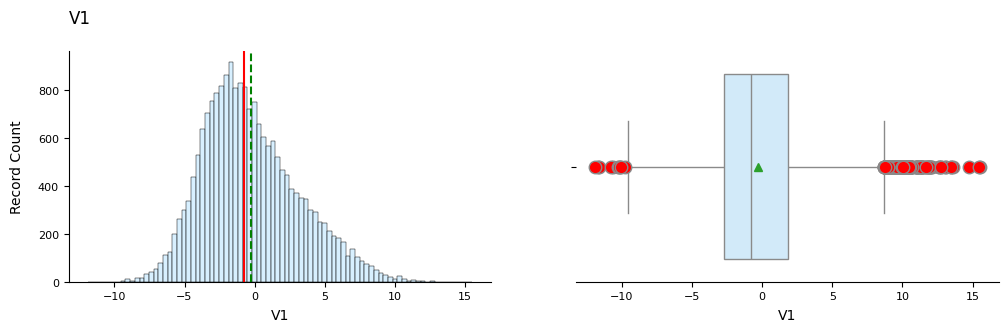

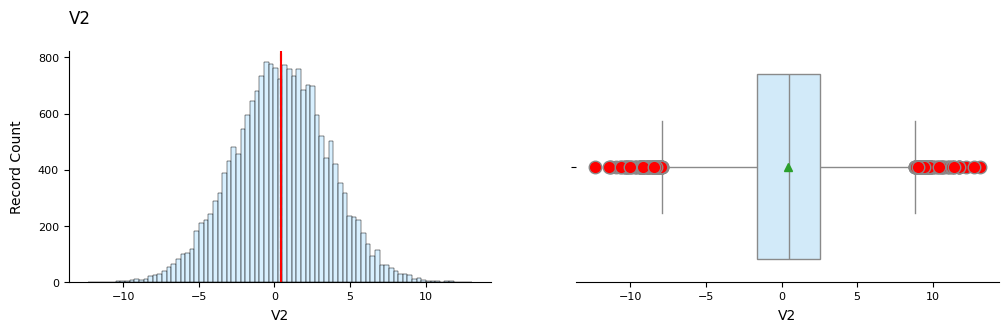

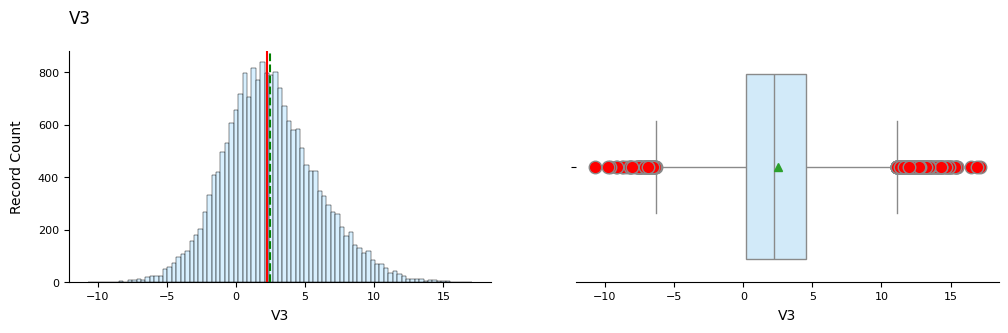

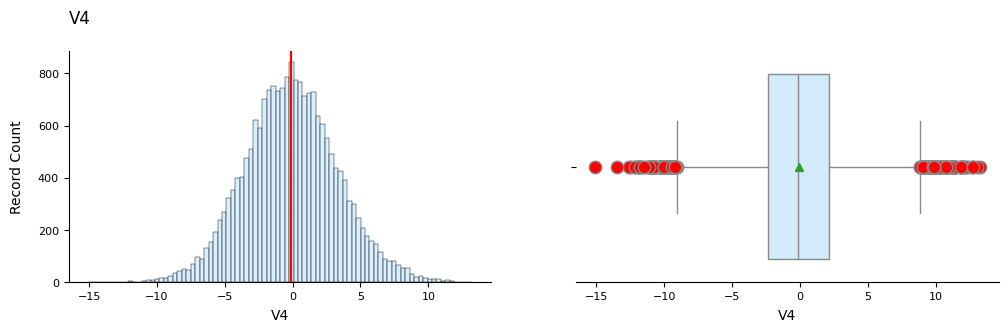

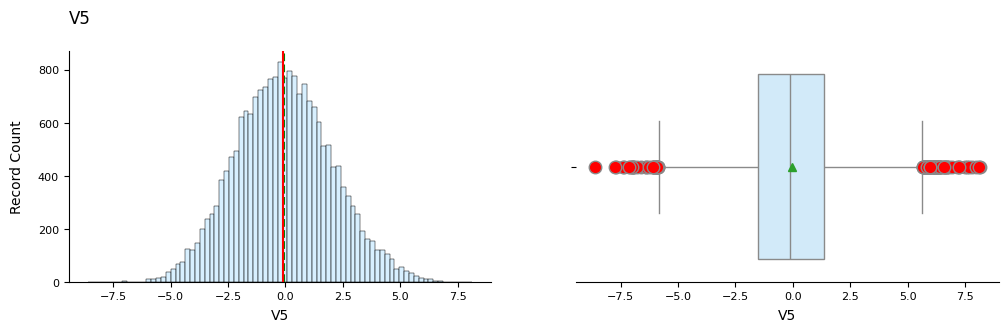

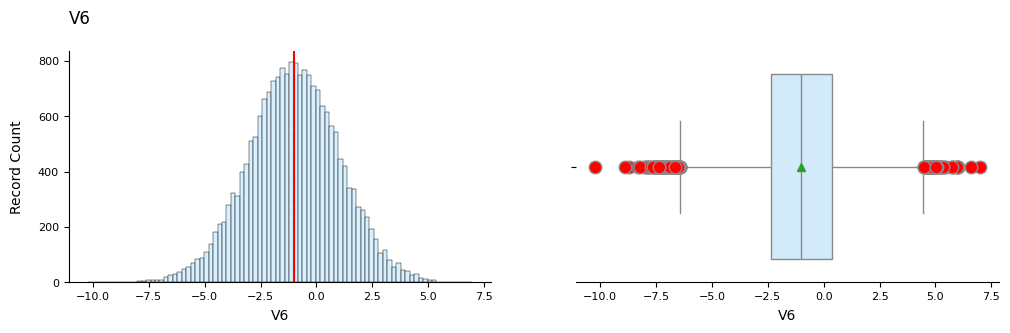

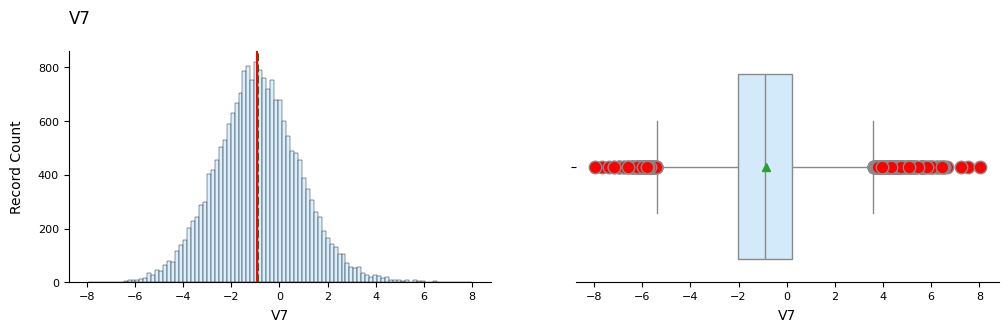

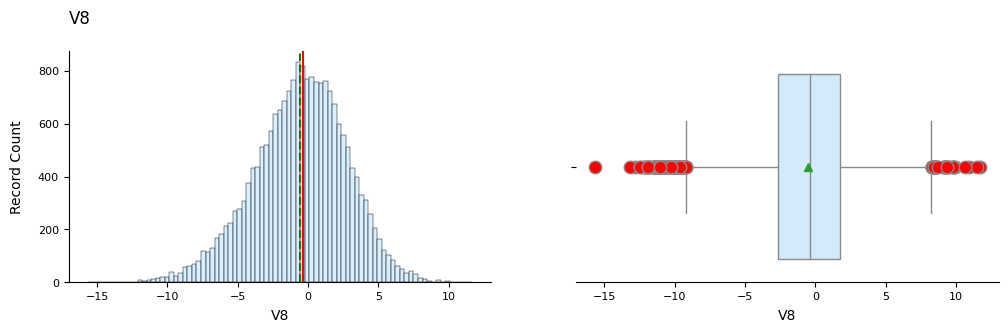

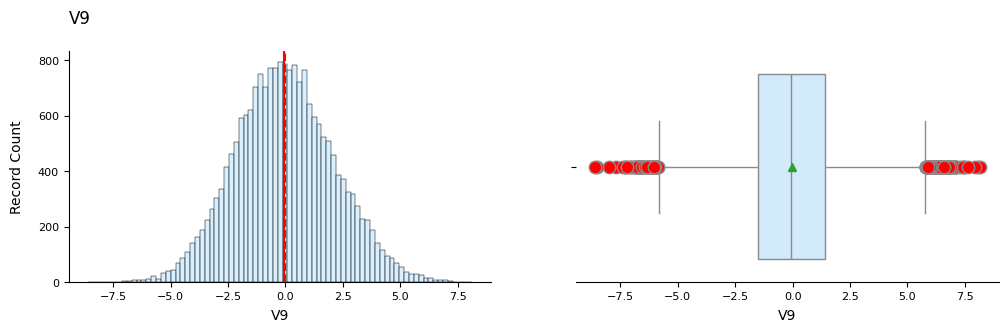

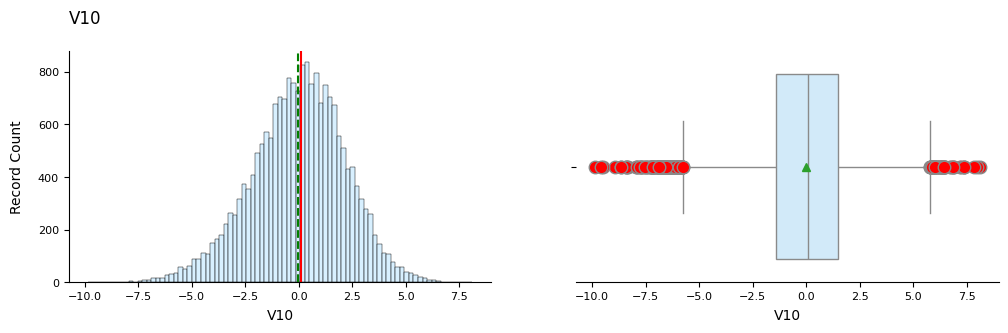

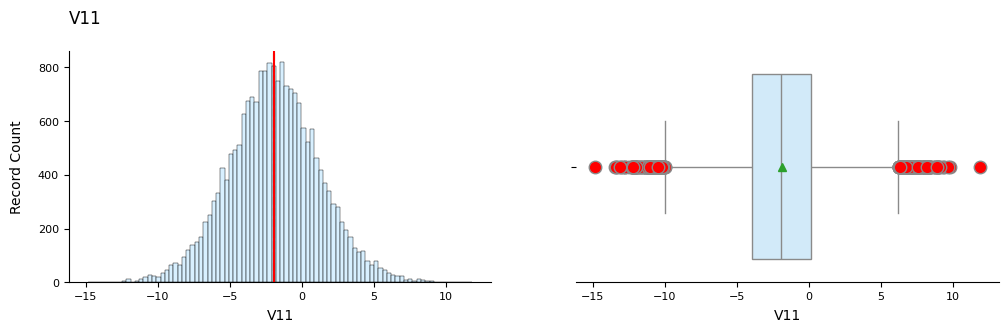

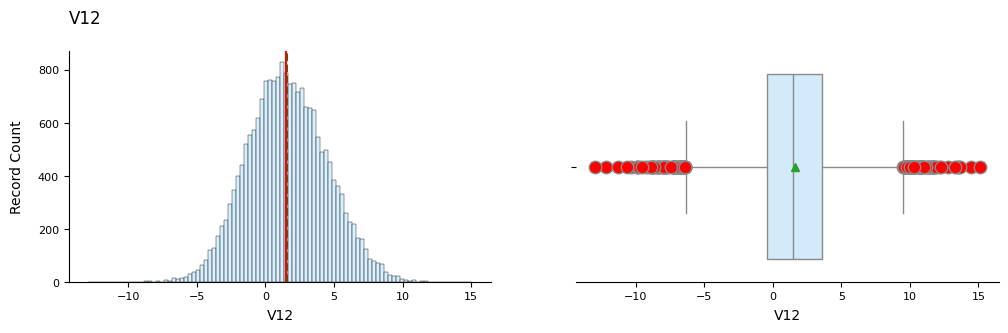

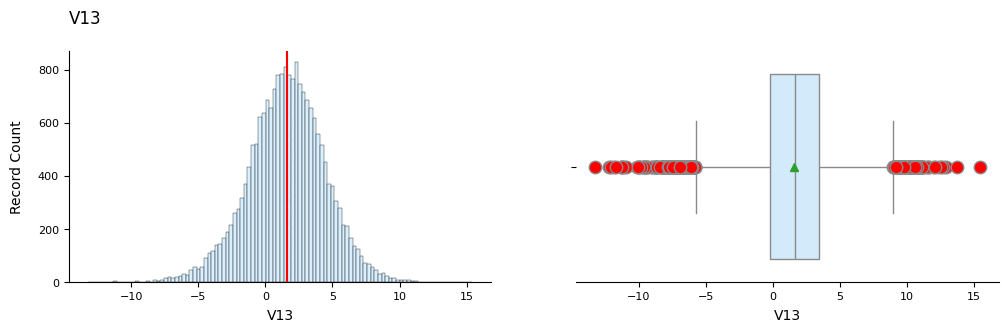

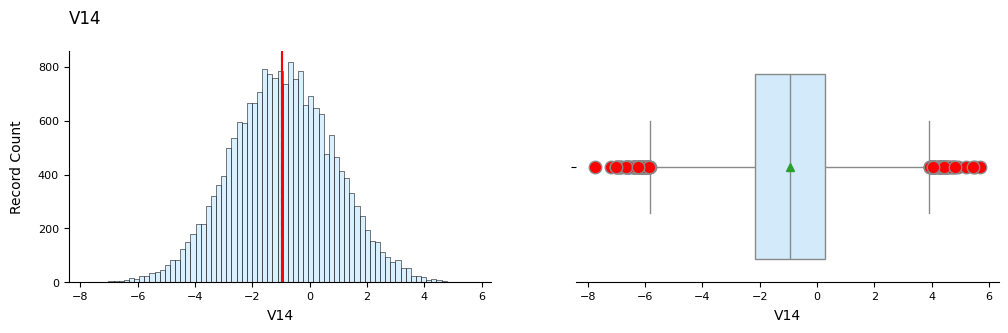

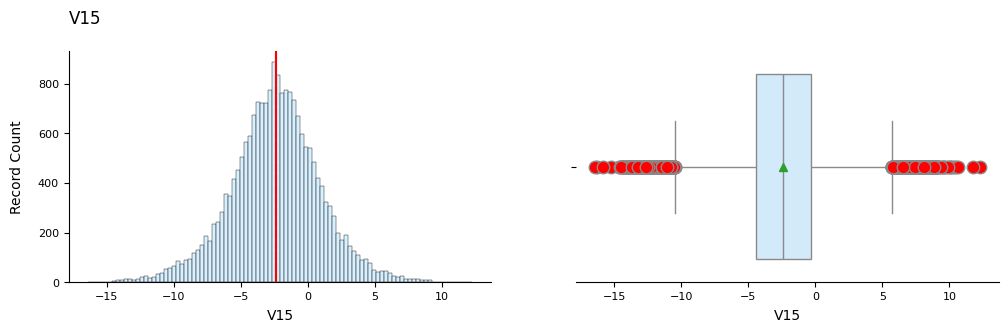

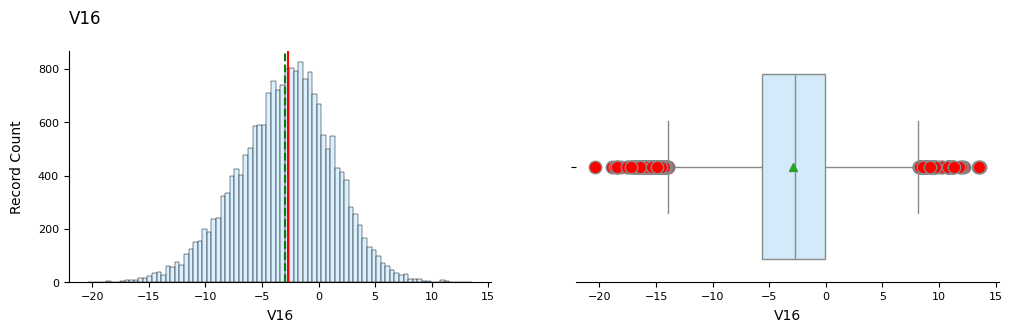

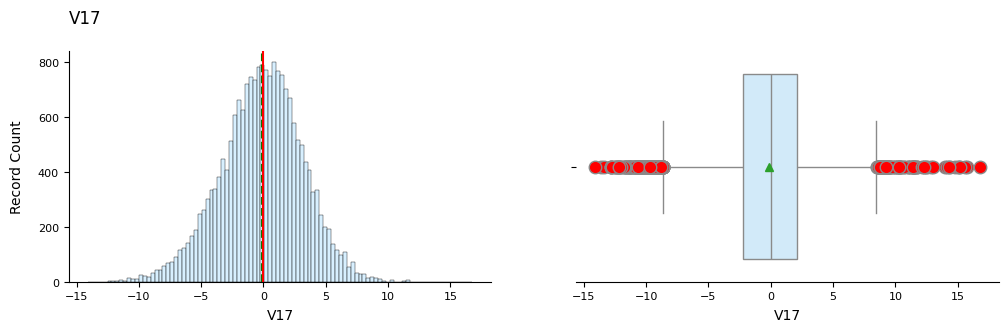

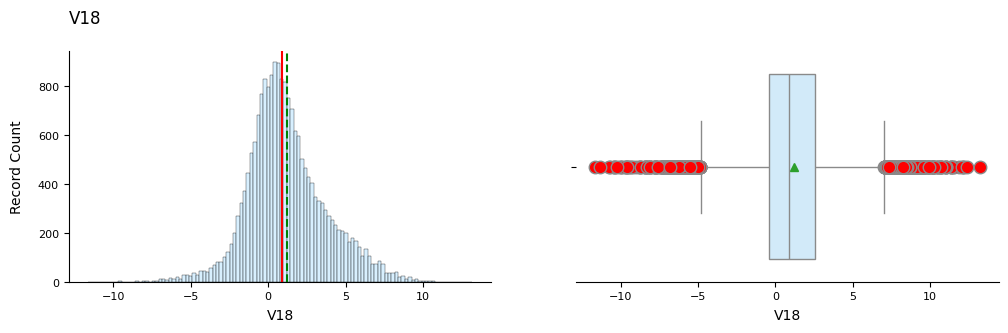

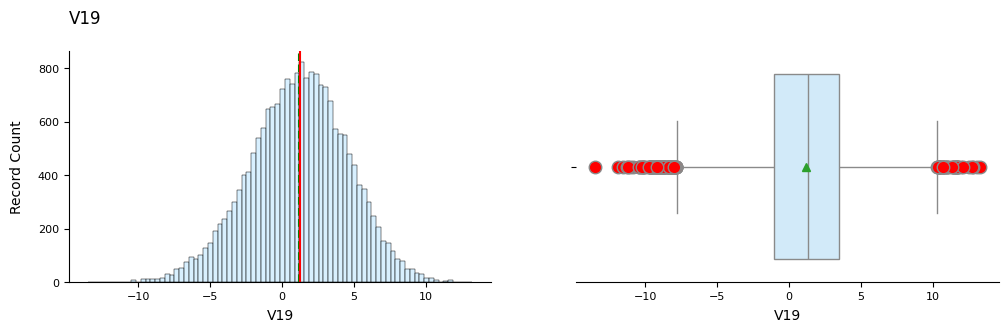

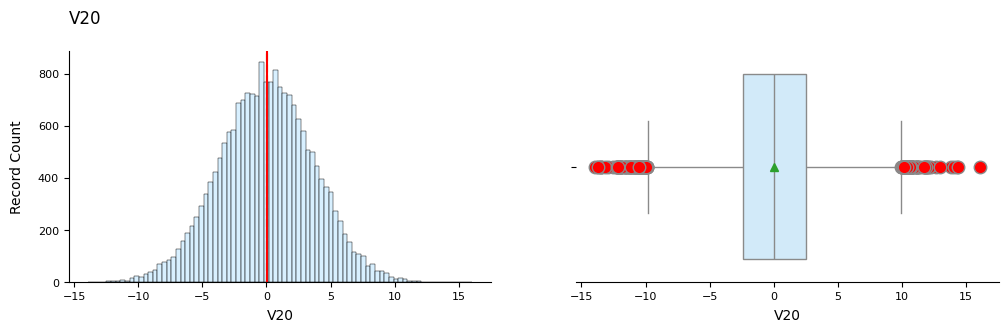

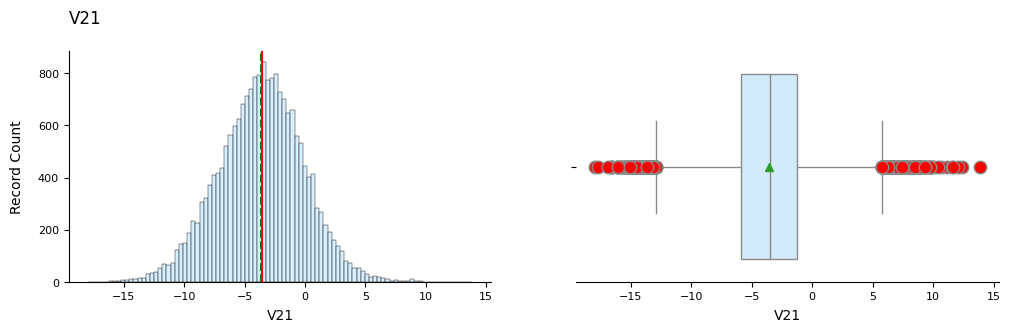

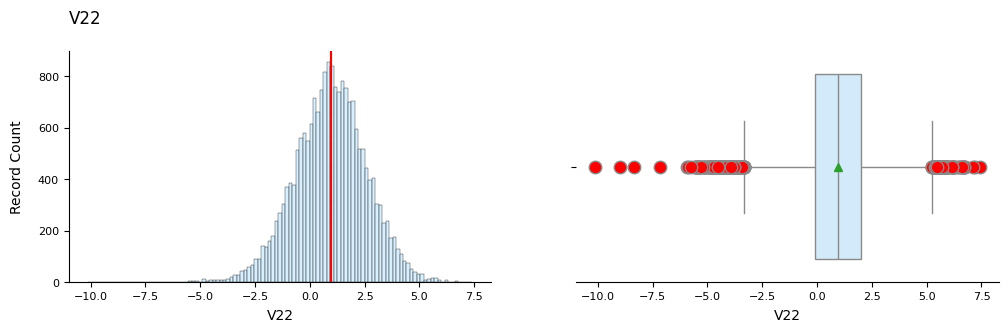

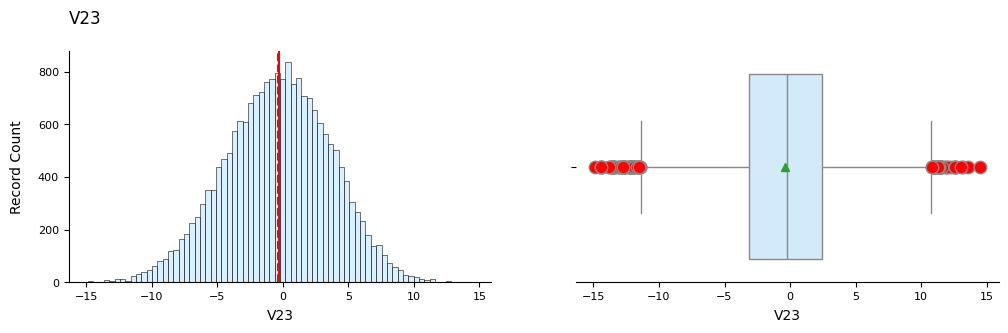

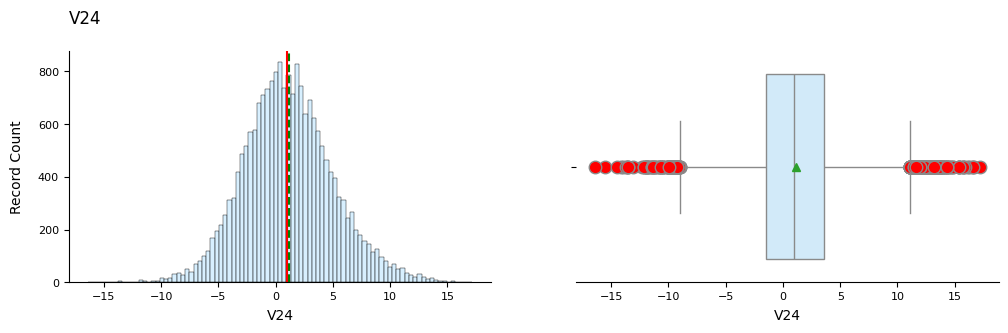

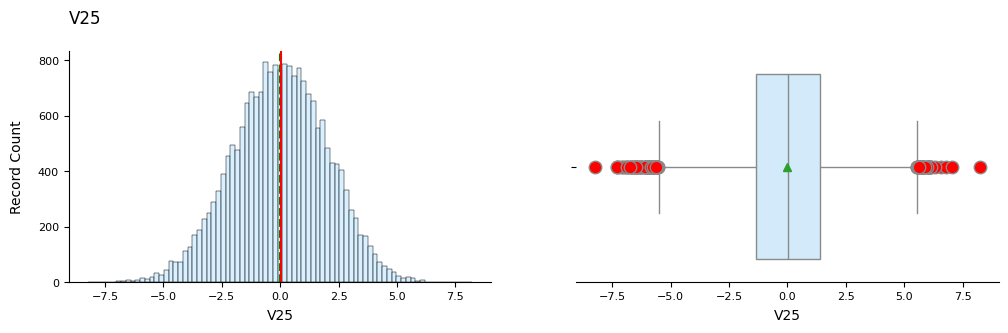

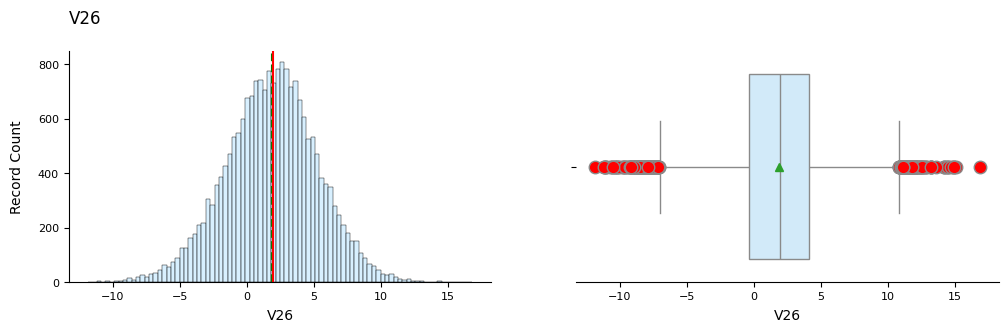

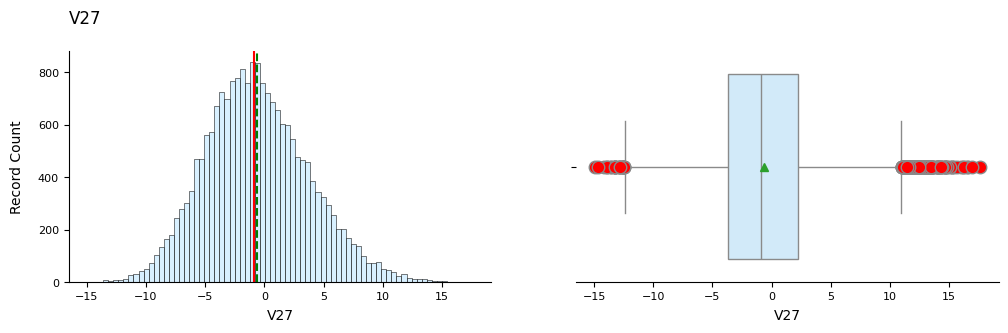

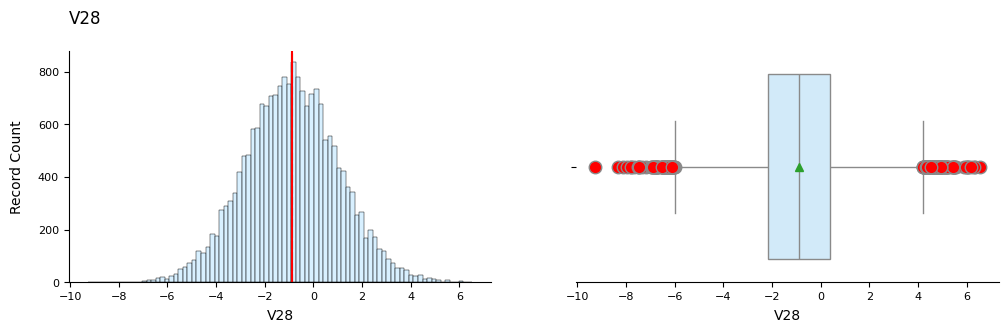

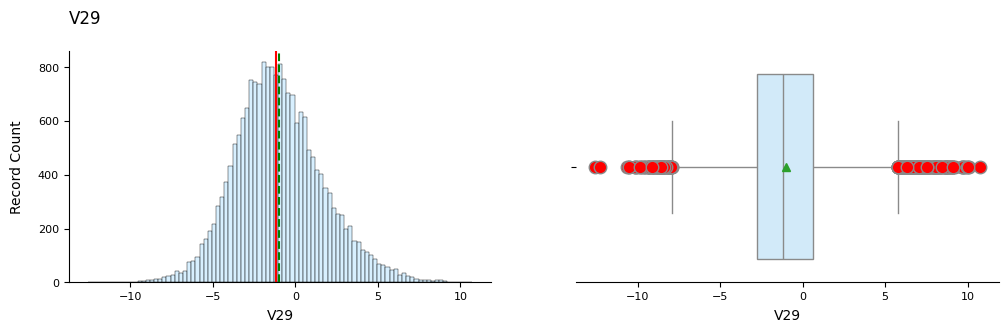

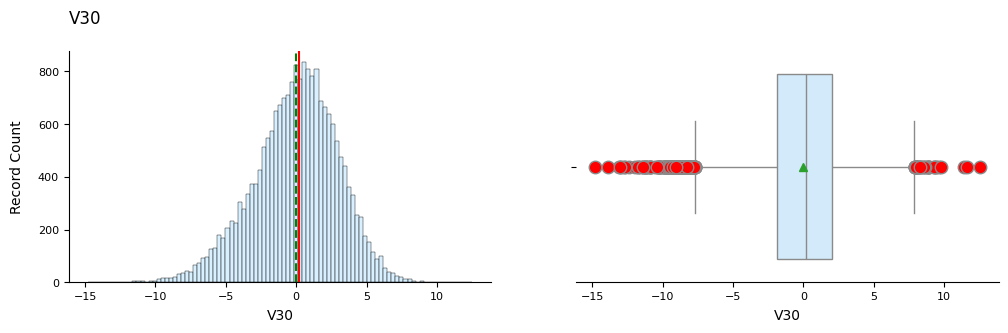

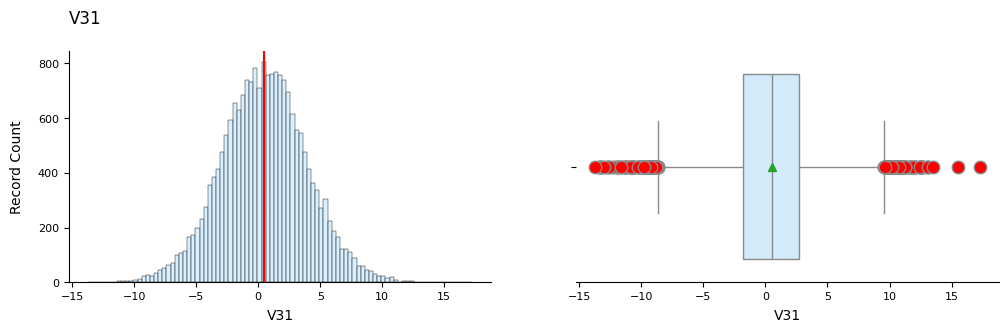

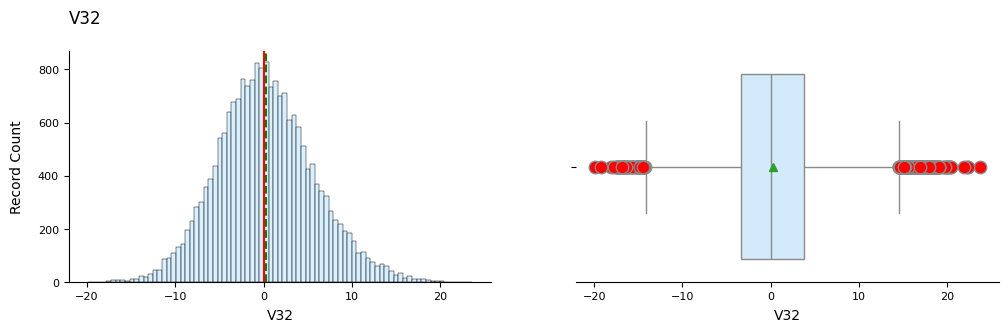

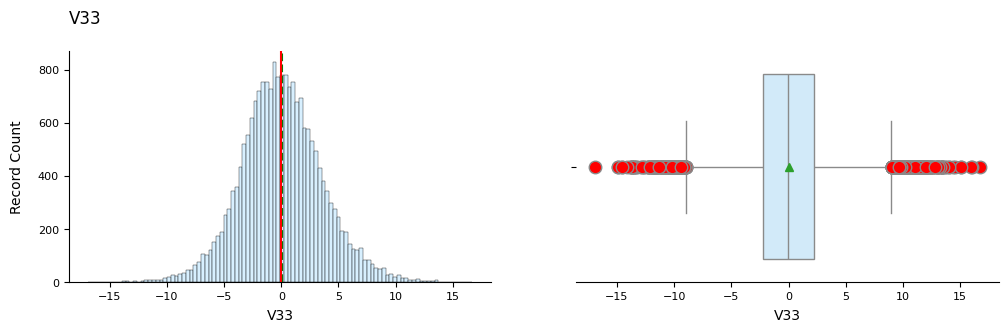

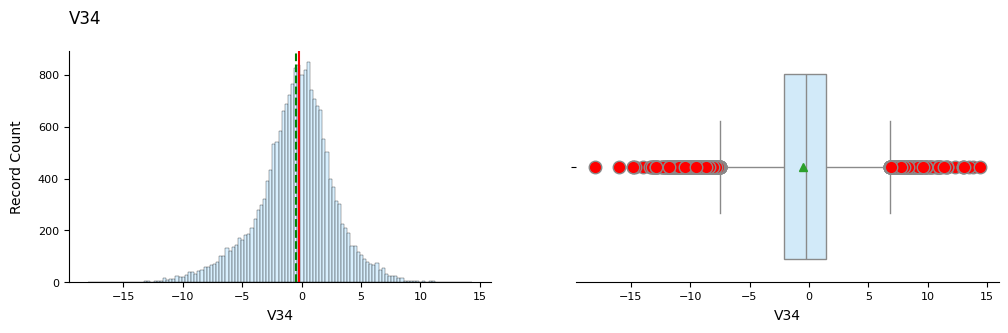

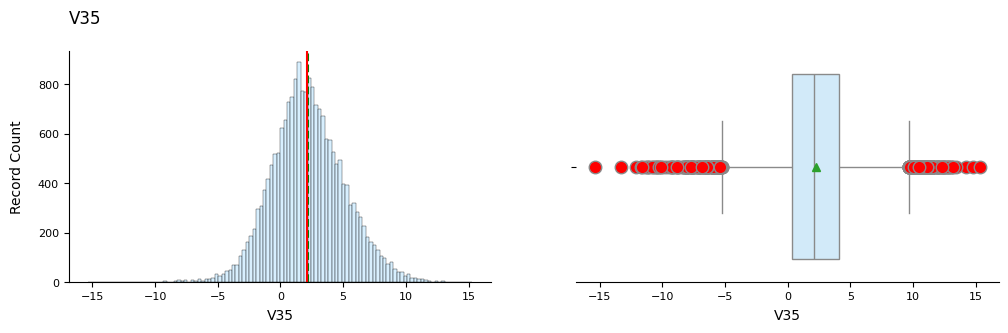

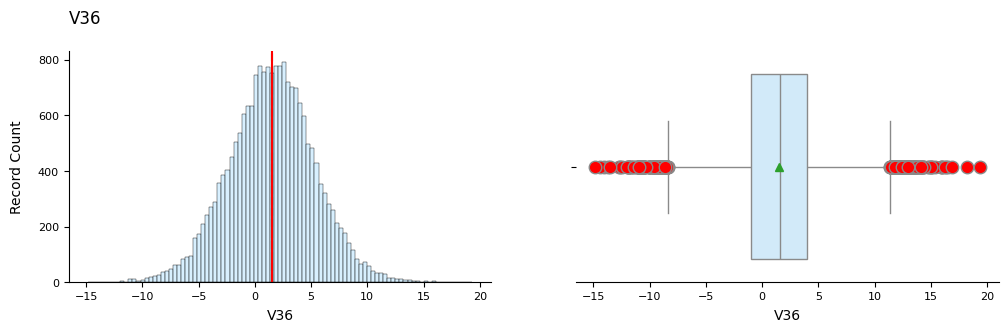

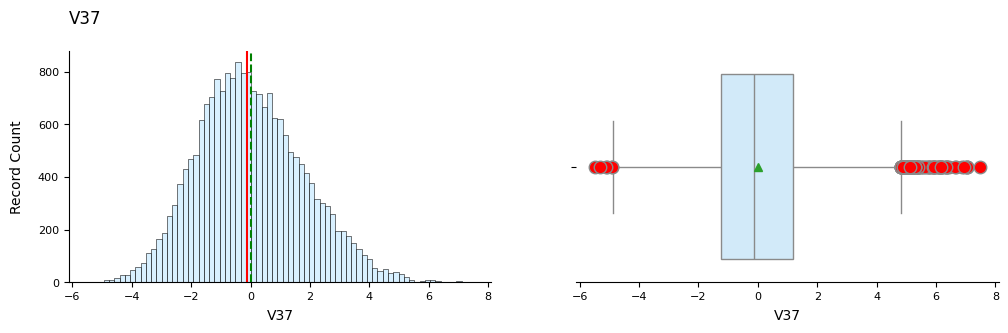

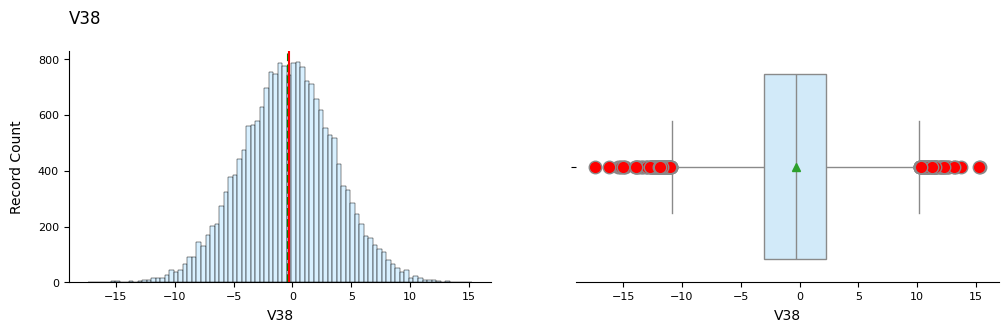

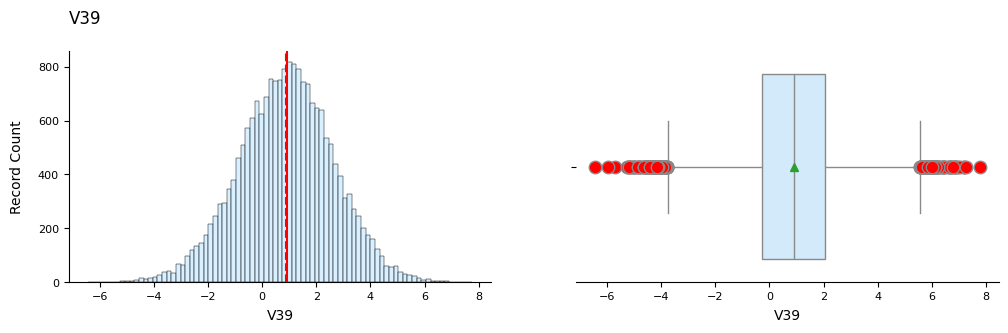

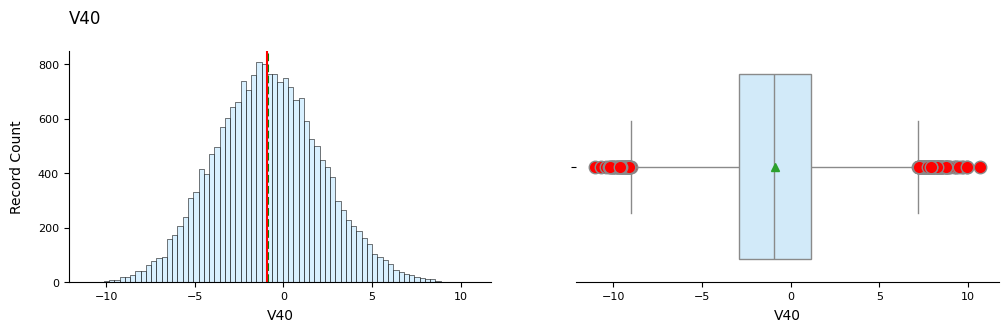

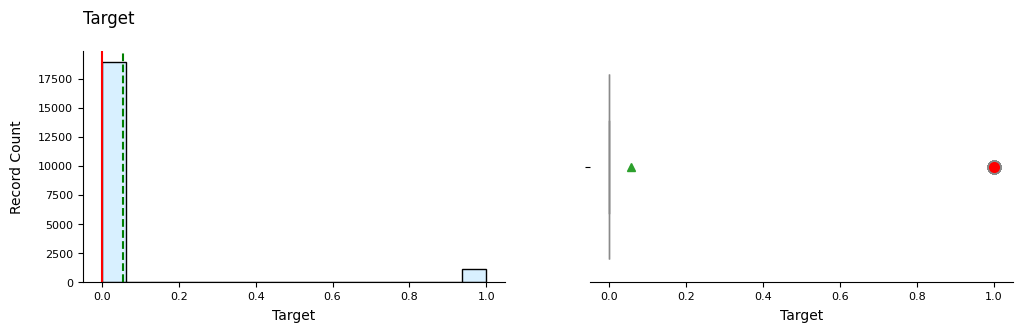

In [17]:
for feature in df.columns:
    hist_boxplots(df, feature) 

#### Observations:
 * V1, V18 skewed slightly to the right
 * V30 skewed slightly to the left
 * There are left and right outliers on all Vxx columns
 * Target is imbalanced with a large majority of records with no failure (0) 
 
 * Column means between -0.5 and 0.5:V2, V4, V5, V8, V9, V10, V17, V20, V23, V25, V30, V31, V32, V33, V34, V37, V38 
 * Column means between (-1 and -0.5) or (0.5 and 1): V1, V7, V14, V18, V22, V24, V27, V28, V39, V40  
 * Column means between (-2 and -1) or (1 and 2): V6, V11, V12, V13, V19, V26, V29, V36
 * Column means between (-3 and -2) or (2 and 3): V3, V15, V16, V35 
 * Column means between (-4 and -3) or (3 and 4): V21 

In [18]:
# Create density plot for one category and one numeric column
def distplot_by_cat_and_num_att (data, att, col):
    """
    Create bivariate box plots for one categorical attribute and one numerical attribute
    
    data: dataframe
    att: categorical attribute
    col: numerical attribute
    """
    # Create the plot figure
    plt.figure(figsize=(12,3))
    
    ################################################

    # Target must have 2 valuess
    target_uniq = data[att].unique()
    
    #x_mean = data.col[data[att] == target_uniq[0]].mean()
    x_mean = data.groupby(data[att] == target_uniq[0])[col].mean()
    
    # Creating first density subplot
    plt.subplot(1,2,1)  
    plt.title("Distribution of target for target=" + str(target_uniq[0]))
    ax = sns.histplot(
            data=data[data[att] == target_uniq[0]],
            x=col,
            kde=True,
            color="teal",
            stat='density')

    plt.xlabel(col.replace('_',' ').title(), fontsize=10, labelpad=5)
    plt.xticks(np.arange(-10,11,2))
    
    # Add a mean to the histogram
    ax.axvline(x_mean[1], color='red', linestyle='--')
    
    # Create second density subplot
    plt.subplot(1,2,2)
    plt.xlabel(col.replace('_',' ').title(), fontsize=10, labelpad=5)
    col.replace('_',' ').title()
    plt.title("Distribution of target for target=" + str(target_uniq[1]))
    ax = sns.histplot(
        data=data[data[att] == target_uniq[1]],
        x=col,
        kde=True,
        color="orange",
        stat='density')
    
    plt.xticks(np.arange(-10,11,2))
    
    # Add a mean to the histogram
    ax.axvline(x_mean[0], color='red', linestyle='--')
    
    
    plt.show

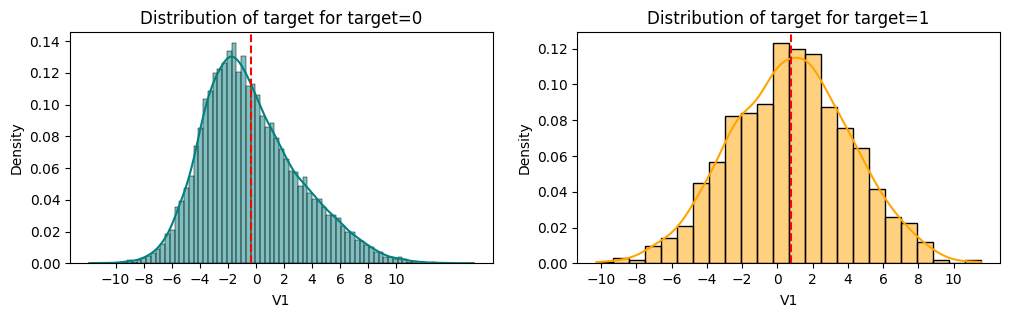

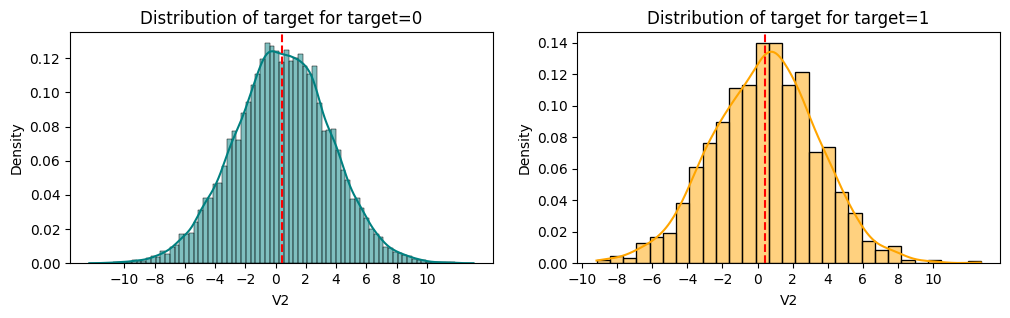

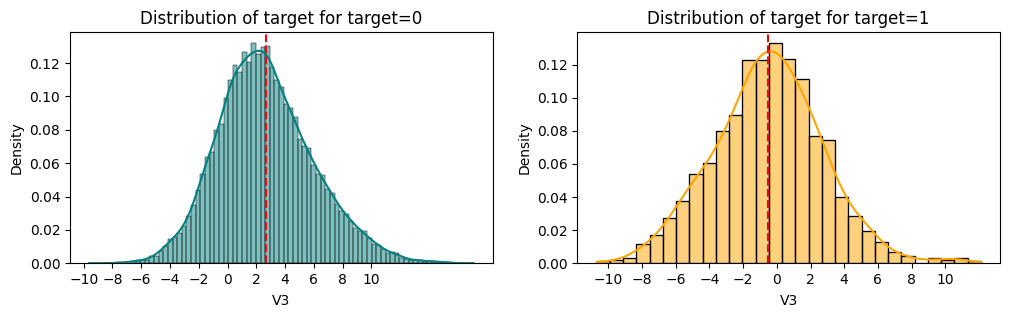

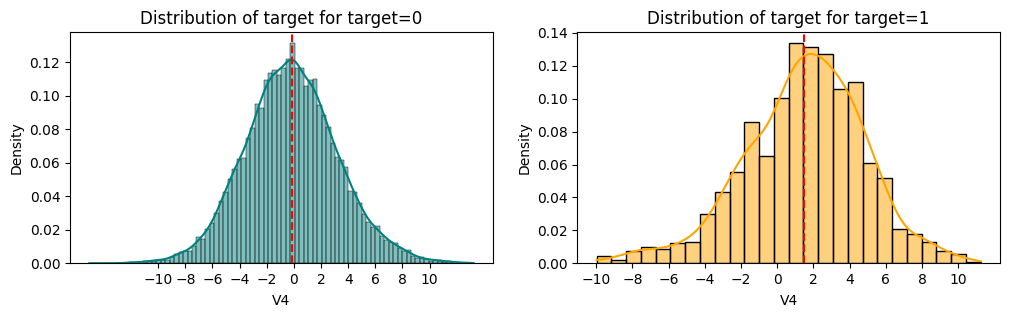

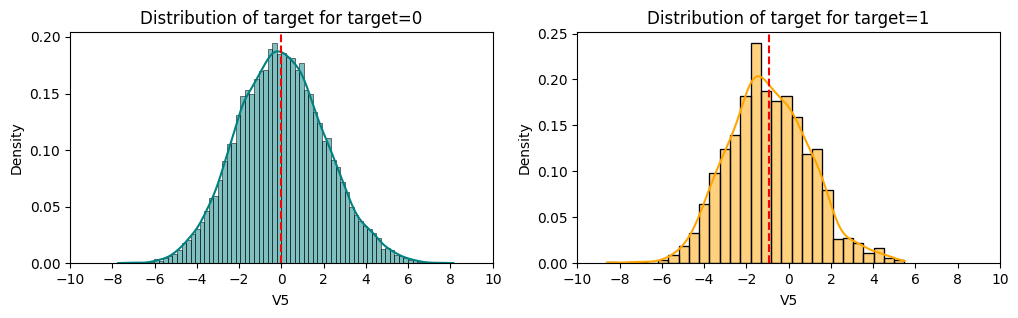

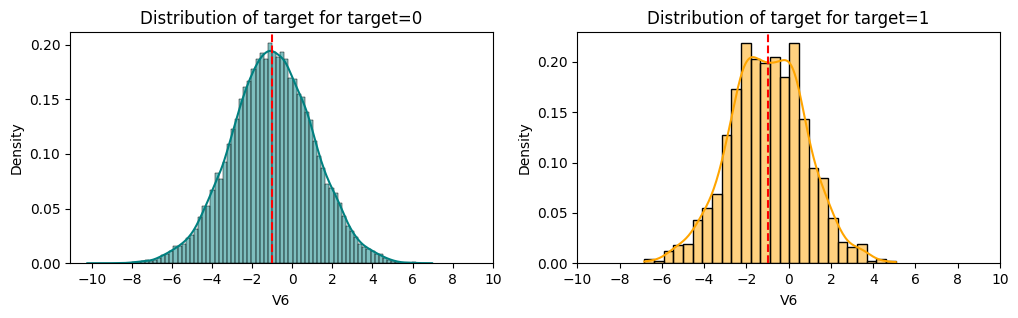

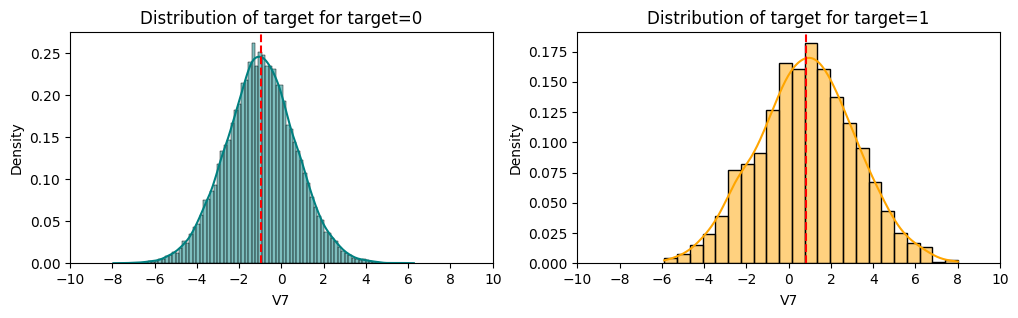

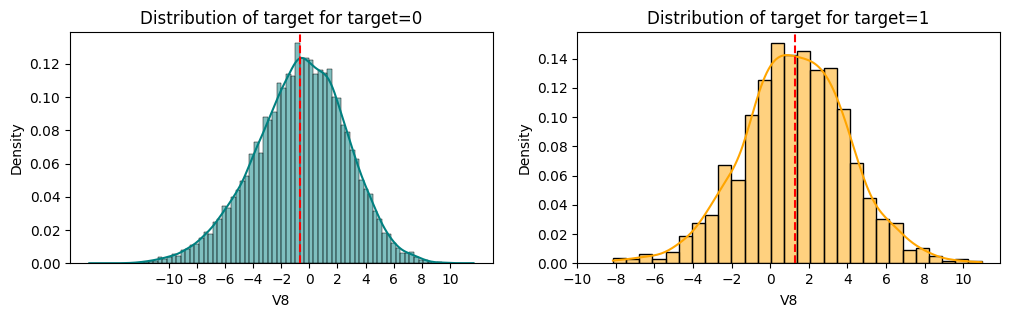

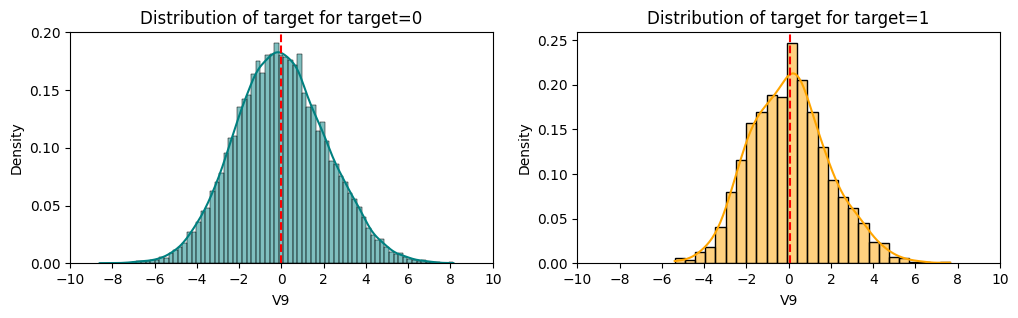

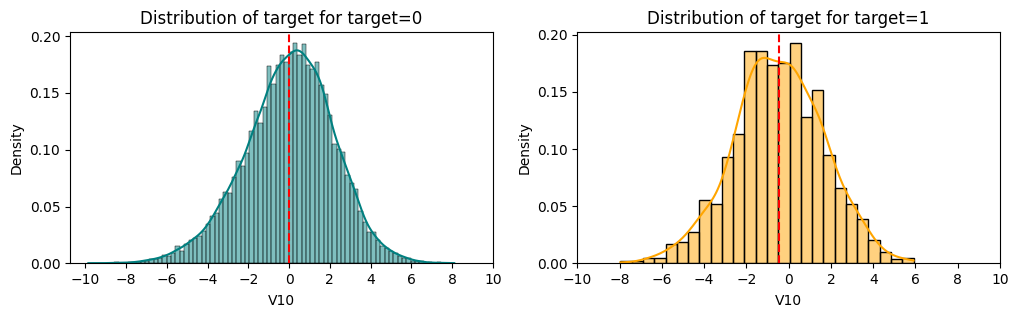

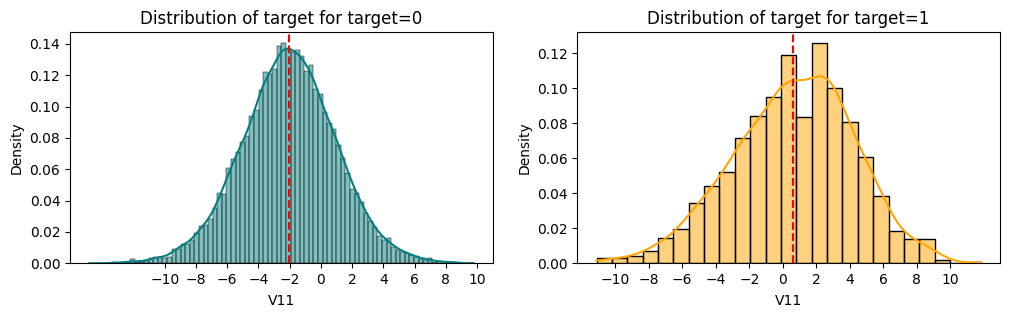

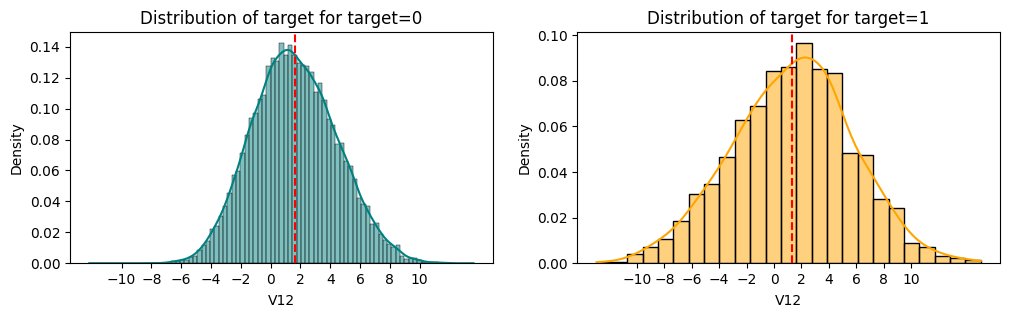

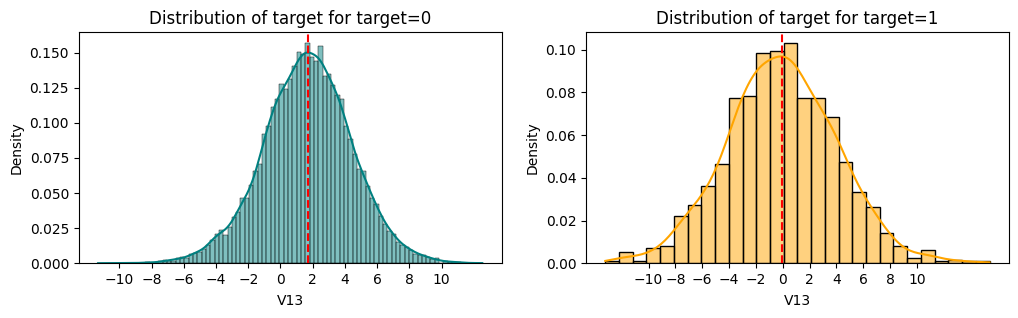

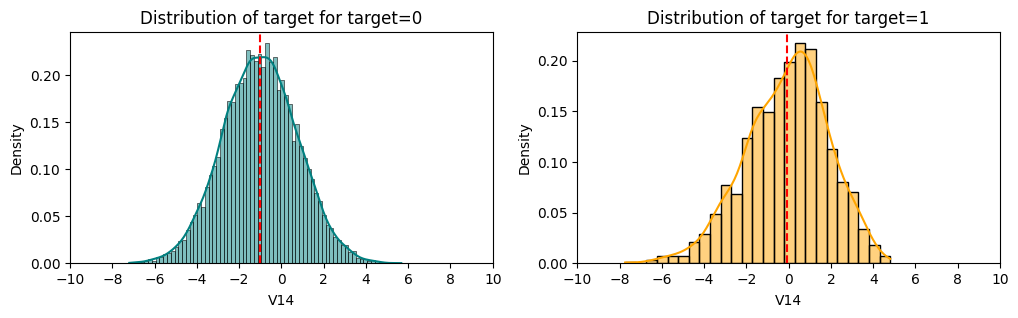

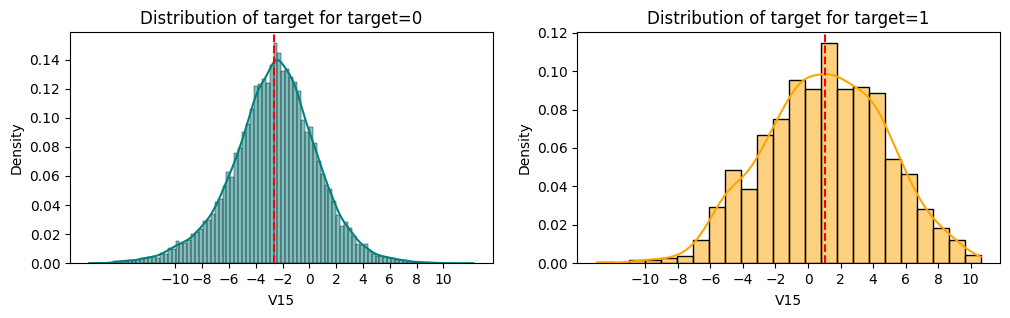

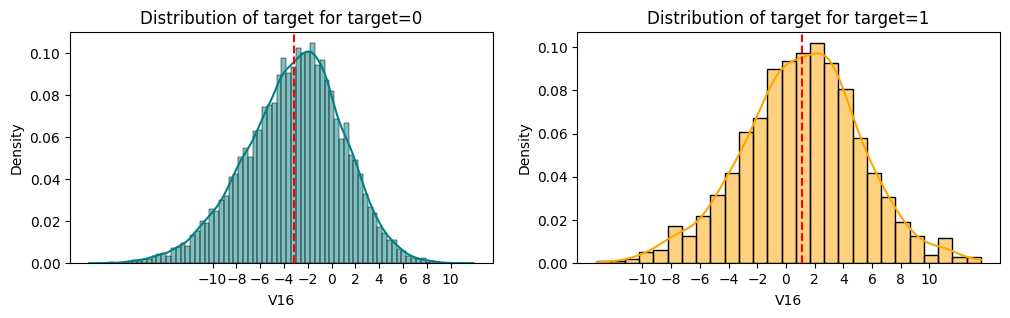

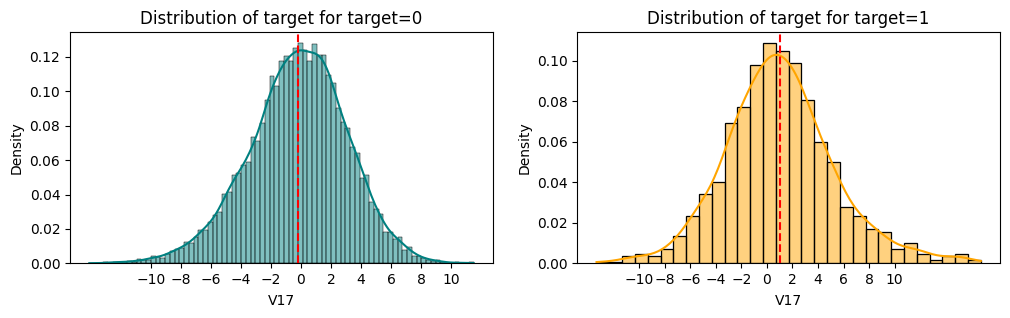

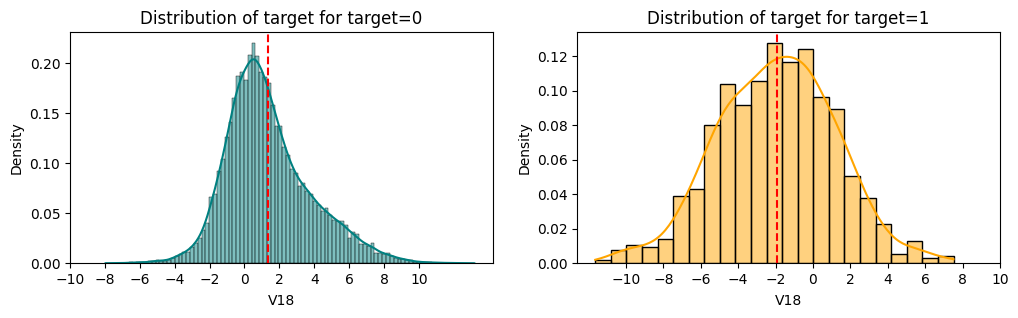

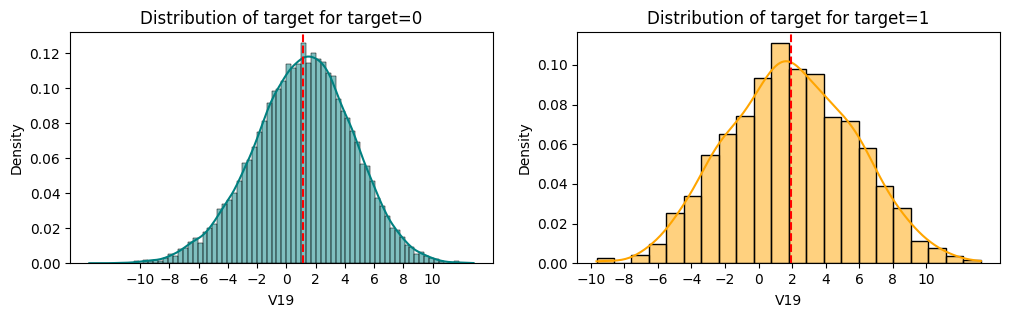

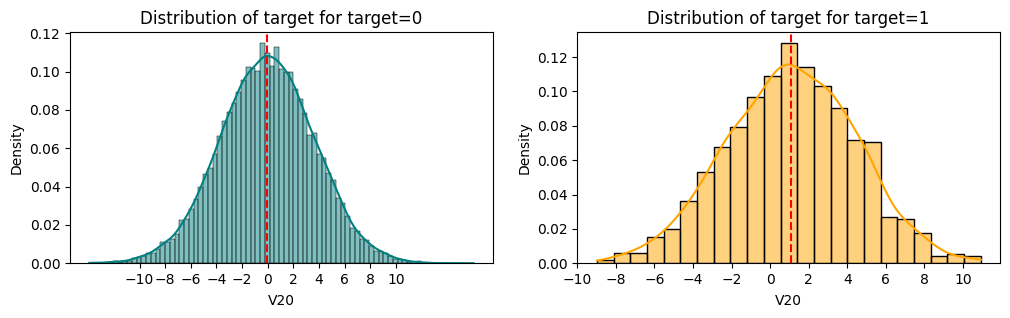

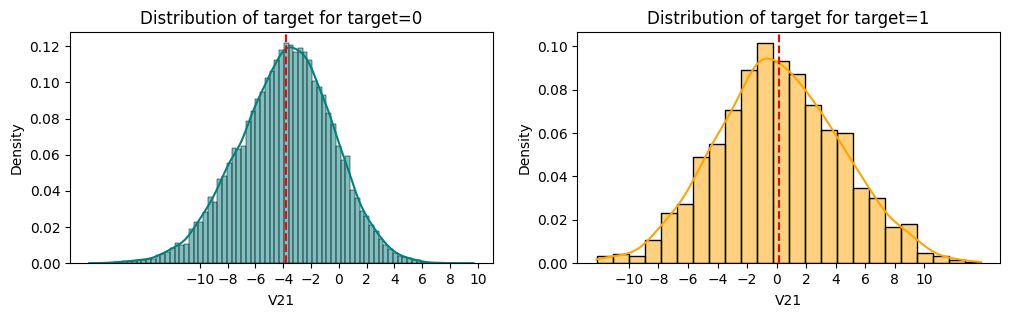

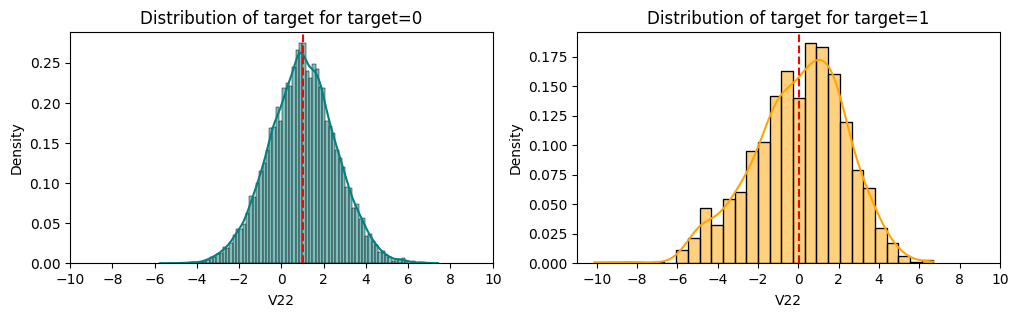

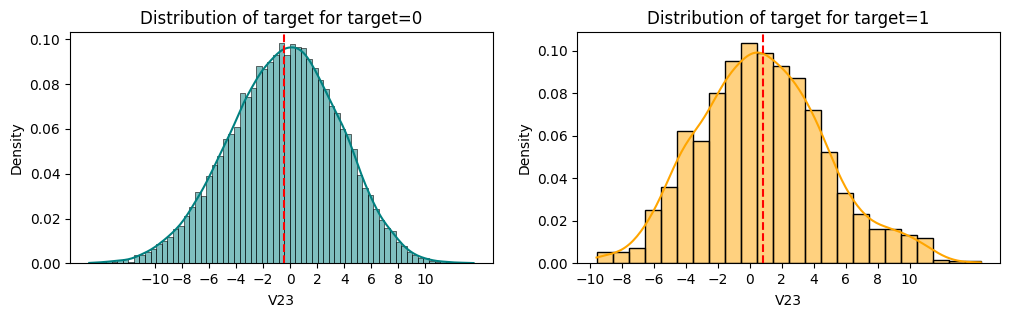

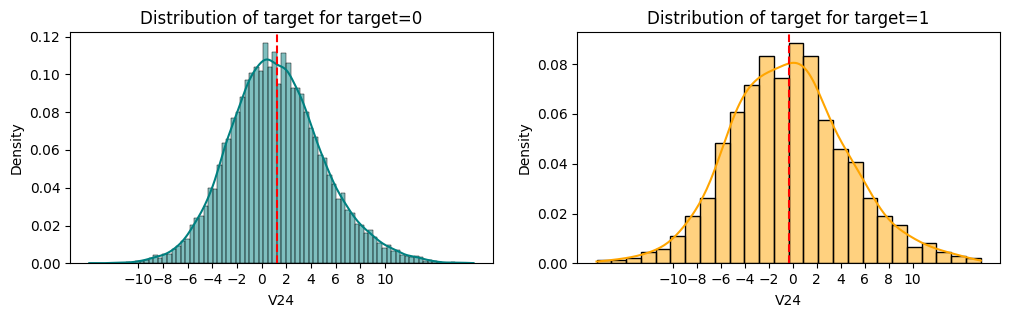

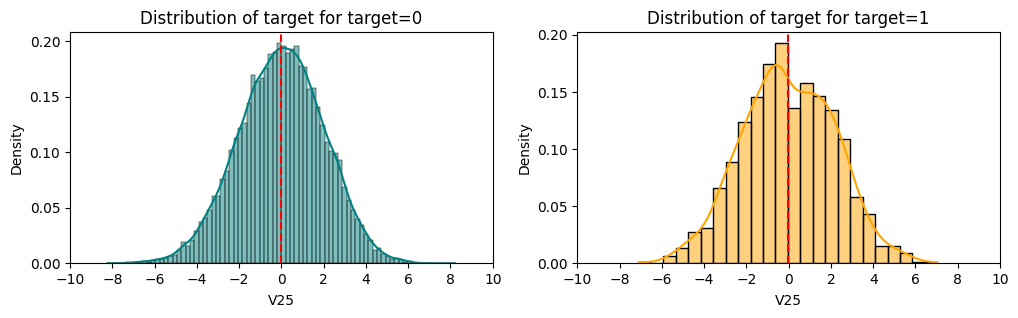

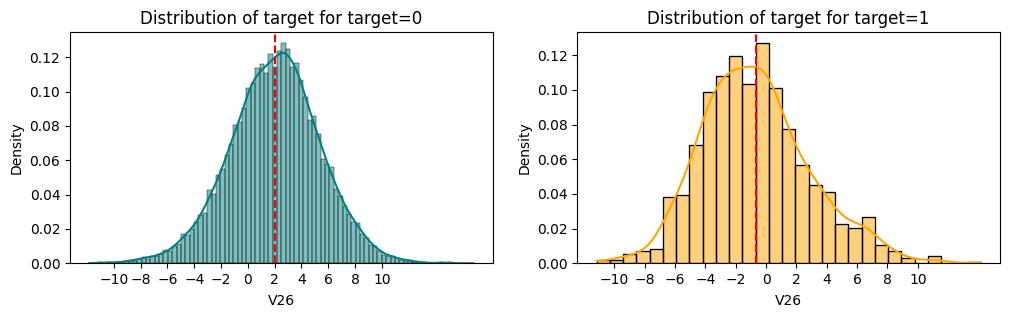

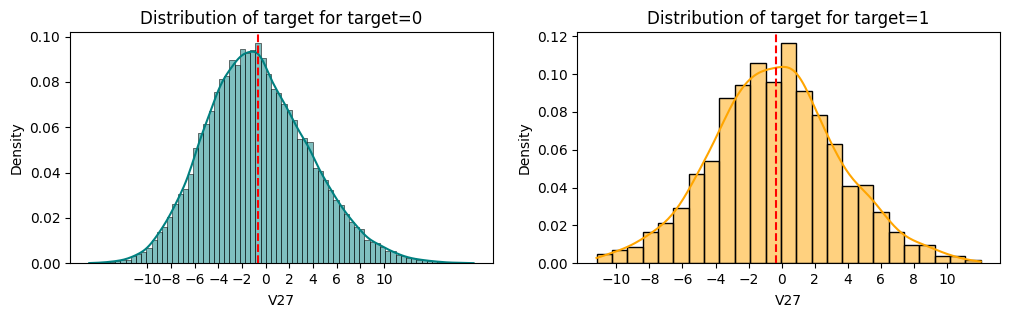

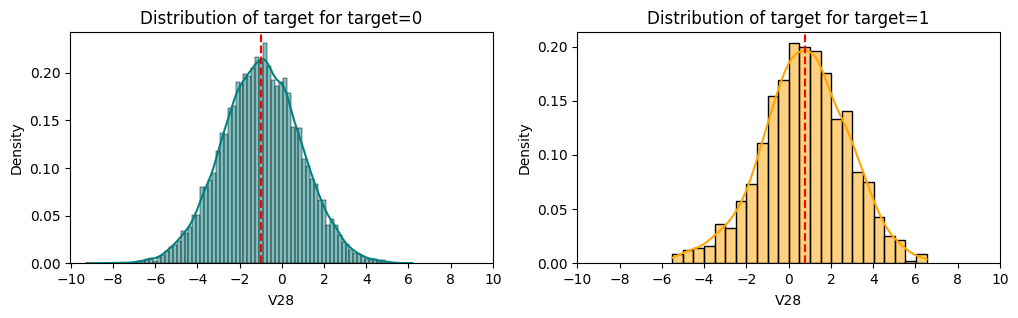

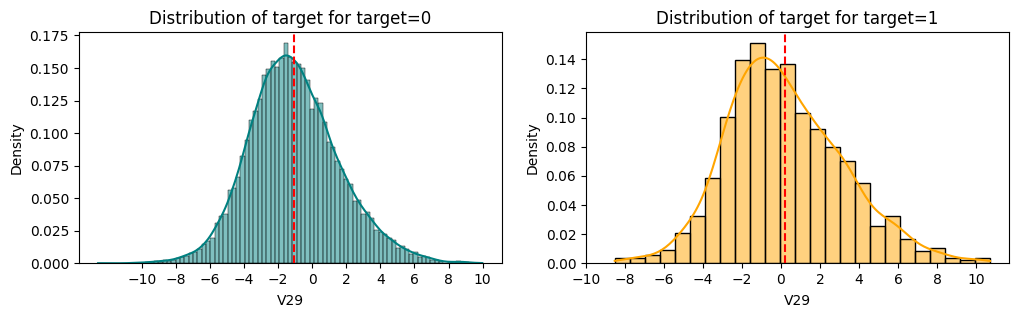

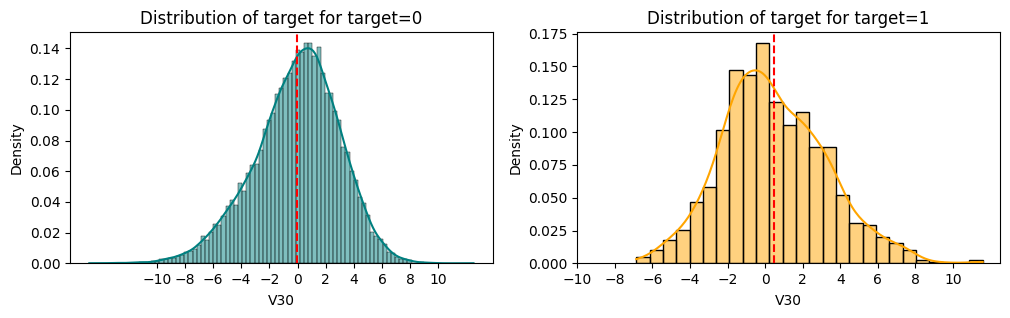

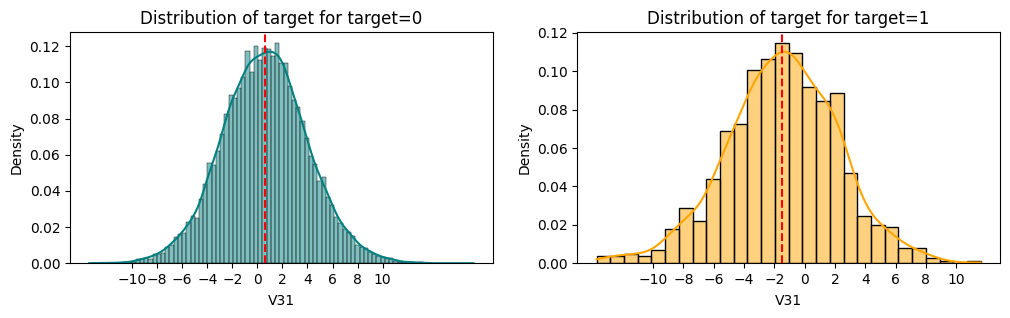

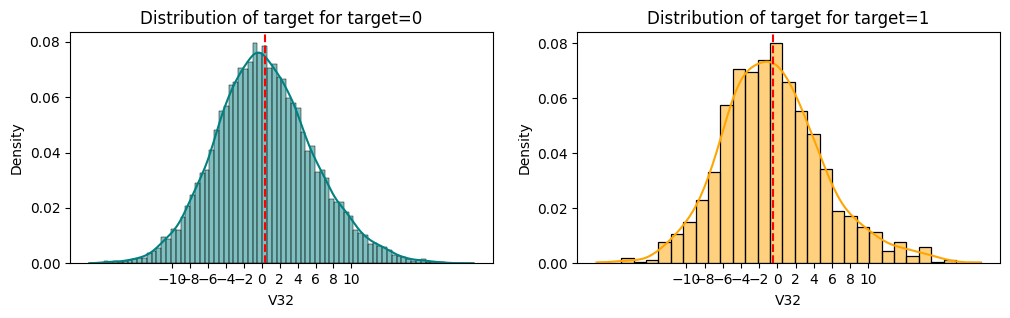

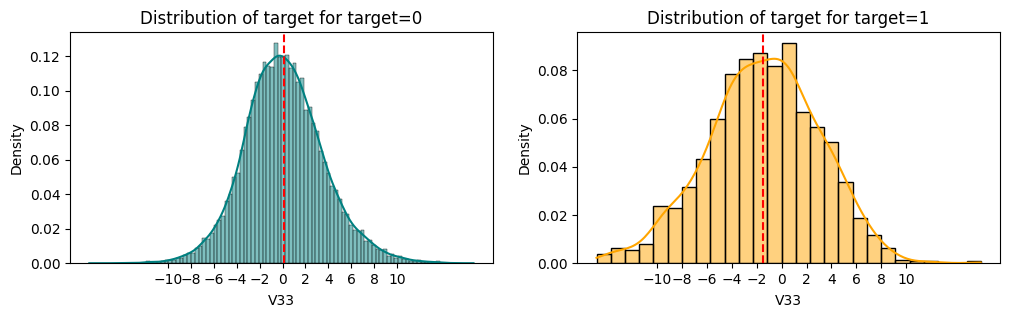

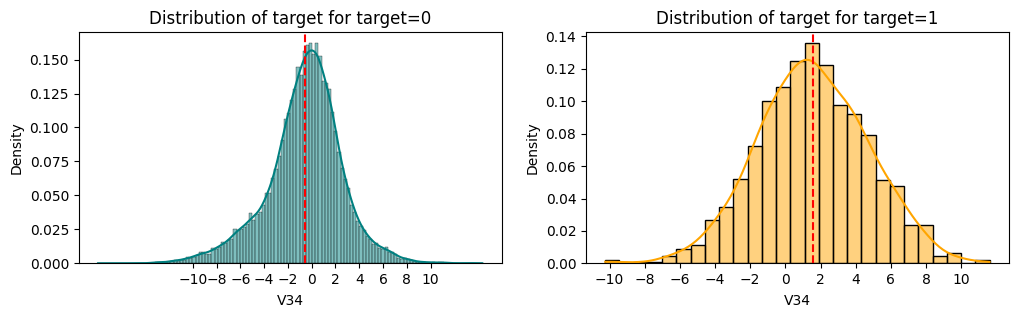

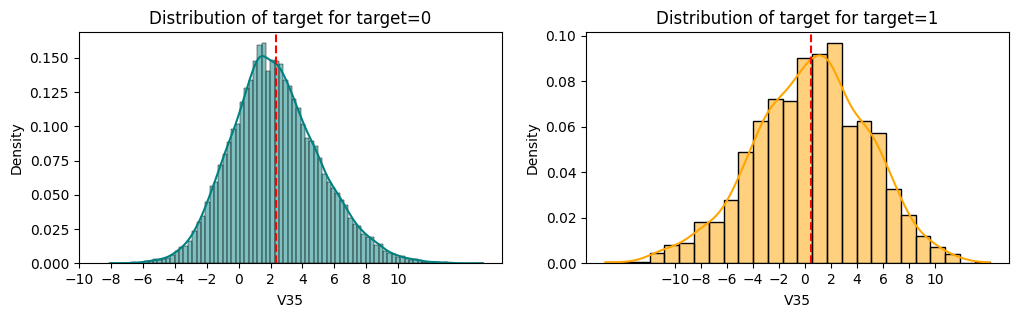

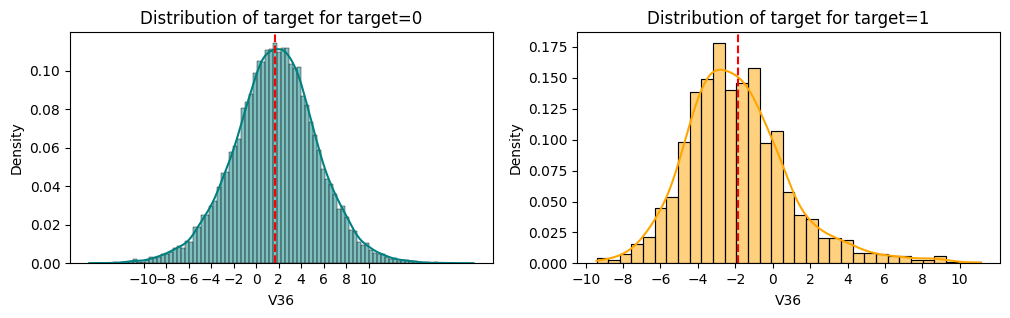

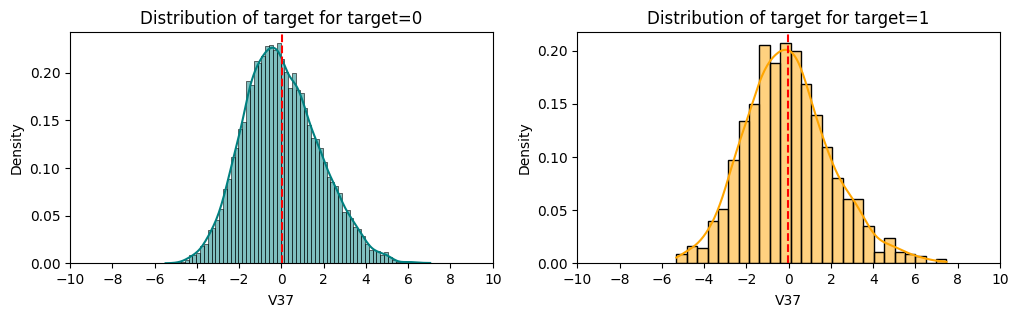

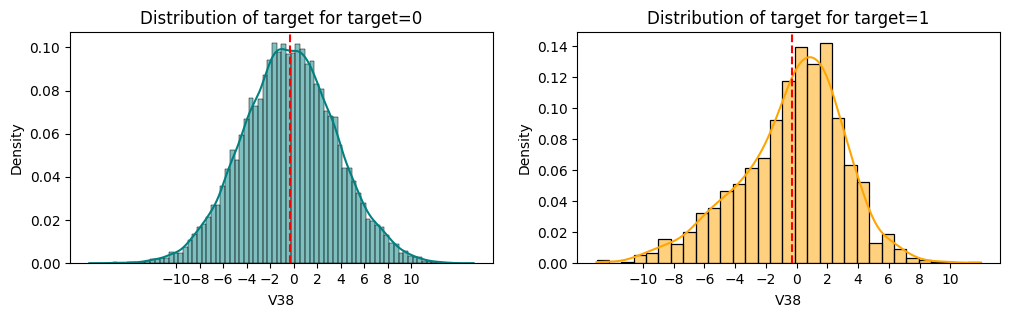

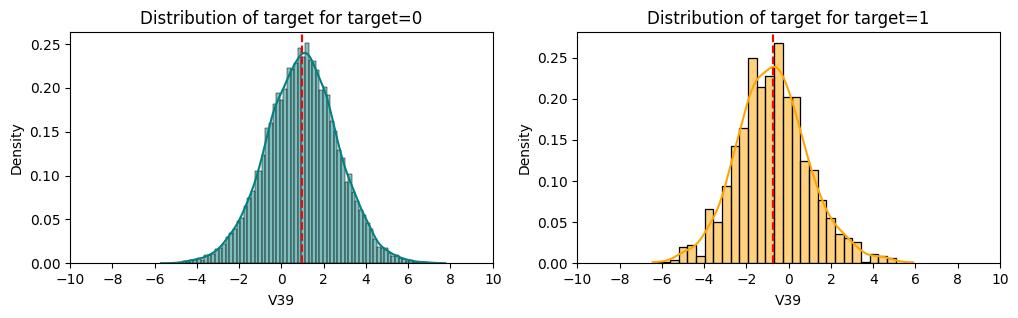

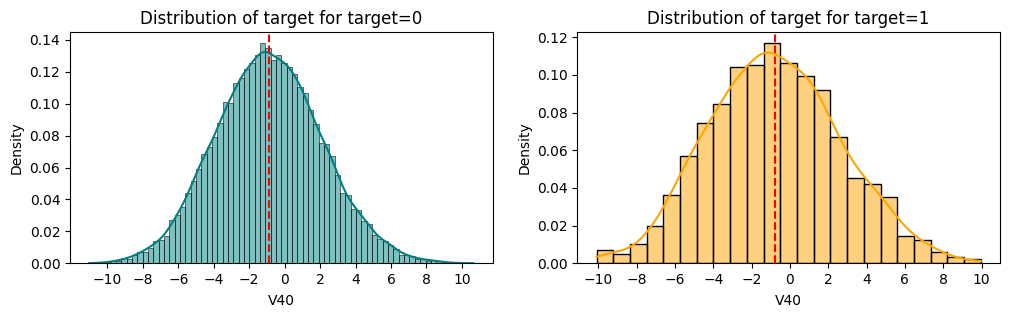

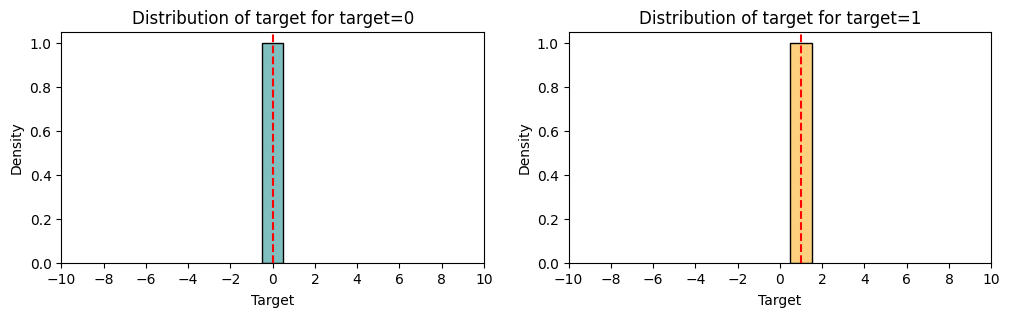

In [19]:
# Create distribution plots and box plots for the listed numerical attributes by case_status

for feature in df.columns:
    distplot_by_cat_and_num_att(df, 'Target', feature)  

#### Observations:
 * Columns that have a higher mean for failures vs non-failures:
   V1, V4, V7, V8, V11, V14, V15, V16, V17, V20, V21, V23, V28, V29, V34 
 * Columns that have a lower mean for failures vs non-failures:
   V3, V5, V10, V13, V18, V22, V24, V26, V31, V32, V33, V35, V36, V39 
 * Columns that have similar means for failures vs non-failures
   V2, V6, V9, V12, V19, V25, V27, V30, V37, V38, V40

In [20]:
# Calculate the percentage split between 0 and 1 for the training data
df['Target'].value_counts(normalize=True)

Target
0    0.9445
1    0.0555
Name: proportion, dtype: float64

In [21]:
# Calculate the percentage split between 0 and 1 for the testing data
df_test['Target'].value_counts(normalize=True)

Target
0    0.9436
1    0.0564
Name: proportion, dtype: float64

#### Observations:
 * The percentage splits between 'No Failure' (0) and 'Failure' for the training and test sets is approximately the same at 94% (0) and 5% (1) respectively

## Data Pre-processing

In [22]:
# Create copy of the training set
df_copy = df.copy()

In [23]:
# Create copy of the test set
df_test_copy = df_test.copy()

In [24]:
# Record which records originally had a missing value in columns V1 and V2
# create 2 new columns Missing_V1 and Missing_V2 in training set
# '1' is missing value row
df_copy['Missing_V1'] = (df_copy['V1'].isnull()).astype(int)
df_copy['Missing_V2'] = (df_copy['V2'].isnull()).astype(int)

In [25]:
# Show the missing values in the V1 column
df_copy[df_copy['Missing_V1']==1]

V1        V2        V3        V4        V5        V6        V7  \
89    NaN -3.961403  2.787804 -4.712526 -3.007329 -1.541245 -0.881148   
5941  NaN  1.008391  1.227702  5.397082  0.064230 -2.706919 -2.028368   
6317  NaN -5.205346  1.997652 -3.707913 -1.042200 -1.593126 -2.653309   
6464  NaN  2.146202  5.004415  4.192063  1.427887 -6.438263 -0.931339   
7073  NaN  2.534010  2.762821 -1.673718 -1.942214 -0.029961  0.911323   
8431  NaN -1.398710 -2.008106 -1.750341  0.932279 -1.290327 -0.270476   
8439  NaN -3.840585  0.197220  4.147789  1.151400 -0.993298 -4.732363   
11156 NaN -0.666978  3.715829  4.934000  1.667596 -4.356097 -2.823137   
11287 NaN -2.561519 -0.180836 -7.194814 -1.043832  1.384845  1.306093   
11456 NaN  1.299595  4.382858  1.583219 -0.076564  0.658770 -1.638530   
12221 NaN -2.326319 -0.051978  0.615063 -0.895755 -2.437003  0.349826   
12447 NaN  0.752613 -0.271099  1.301204  2.038697 -1.485203 -0.411939   
13086 NaN  2.056243  3.330642  2.741497  2.783166 -0.444191 -2.015376   
13411 NaN  2.704511  4.587169  1.867930  2.050133 -0.925076 -1.669496   
14202 NaN  7.038653  2.144536 -3.201788  4.112972  3.375972 -1.337179   
15520 NaN  1.382556  3.236896 -3.818363 -1.917264  0.437686  1.347540   
16576 NaN  3.933815 -0.761930  2.651889  1.753614 -0.554092  1.829107   
18104 NaN  1.492173  2.659206  0.222784 -0.303648 -1.347322  0.044309   

             V8        V9       V10  ...        V34       V35       V36  \
89     1.476656  0.574700 -1.100884  ...   1.121314 -0.305907  5.315007   
5941   0.534046  3.006797 -2.362238  ...  -0.550197  1.713781 -2.256960   
6317   0.852280 -1.310489  2.406924  ...  -0.277521  3.196840  7.016205   
6464   3.794120 -0.683032 -0.738941  ...   1.745687  2.587189  3.990777   
7073  -3.199743  2.948610 -0.413229  ...  -1.500807  2.036186 -0.828979   
8431   4.458834 -2.776270 -1.211766  ...  -2.037313  1.109793  1.520594   
8439   0.558966 -0.926683  0.457914  ...   0.241818  3.215765  1.203210   
11156  0.373175 -0.709951  2.177428  ...   3.068461  2.486862  4.808548   
11287  1.559192 -2.992173  1.274543  ...  -1.153884 -0.019205  4.065248   
11456 -4.814763 -0.914819  2.811808  ...   1.203739  5.663939  0.413630   
12221  2.092611 -2.933523  2.291272  ...   5.251667  0.716371  3.210930   
12447  0.980629  0.810336 -0.065120  ...  -1.358706 -1.725697  1.679060   
13086 -0.887154 -1.110920  0.025289  ...  -1.709632  2.429762  0.996644   
13411 -1.653803 -0.243383 -0.317316  ...  -1.200200  2.328028  1.666937   
14202 -4.546371  1.941427 -5.466593  ... -10.258190  0.513864 -1.974958   
15520 -2.036067  1.155712  0.306502  ...  -1.057864  1.417365  1.161990   
16576 -0.105409 -3.737081  1.036776  ...   2.845747  1.744060 -1.999615   
18104 -0.159095  1.108116 -0.572670  ...  -0.870845  1.299595  0.667952   

            V37       V38       V39       V40  Target  Missing_V1  Missing_V2  
89     3.750044 -5.631174  2.372485  2.195956       0           1           0  
5941   0.410992 -3.434400 -1.299388 -1.768734       0           1           0  
6317   1.302334 -4.580096  2.956254 -2.363150       0           1           0  
6464   0.610716 -4.273457  1.864568 -3.599079       0           1           0  
7073  -1.369591  0.572366 -0.132183 -0.322007       0           1           0  
8431   2.113872 -2.252571 -0.939249  2.542411       0           1           0  
8439   1.274857 -1.921229  0.578890 -2.837521       0           1           0  
11156  0.069305 -1.215784  3.013674 -5.972586       0           1           0  
11287  0.978880 -0.571288  0.630374  3.919467       0           1           0  
11456 -2.643934  5.529745  2.104536 -4.945350       0           1           0  
12221  1.641985  1.543559  1.805163 -2.039510       0           1           0  
12447 -0.208564 -2.335547  0.112248 -0.542931       0           1           0  
13086 -1.190509  1.207054  0.511023 -0.884200       0           1           0  
13411 -0.943228  0.946846  1.655145 -1.665439       0           1        

In [26]:
# Show the missing records in the V2 column
df_copy[df_copy['Missing_V2']==1]

V1  V2        V3        V4        V5        V6        V7  \
613   -2.048681 NaN -1.623885 -3.324224  0.152256  0.600157 -1.812802   
2236  -3.760658 NaN  0.194954 -1.637958  1.261479 -1.573947 -3.685700   
2508  -1.430888 NaN  0.659576 -2.876402  1.150137 -0.785760 -1.560174   
4653   5.465769 NaN  4.540947 -2.916550  0.399752  2.798925  0.029477   
6810  -2.631454 NaN  2.330188  1.090080  0.603973 -1.139383 -0.690121   
7788  -4.203459 NaN  2.953868  0.584466  4.103940 -0.639211 -2.810799   
8483  -4.484232 NaN  1.200644 -2.042064  2.779443 -0.801748 -5.403548   
8894   3.263555 NaN  8.446574 -3.253218 -3.417978 -2.995838 -0.669271   
8947  -3.793170 NaN  0.719610  2.306296  0.934728 -0.984321  0.504867   
9362   2.662045 NaN  2.980068  4.430762 -0.237769  0.671919  0.380068   
9425  -2.354134 NaN  2.053893  0.811660  2.540366 -0.924875 -0.208380   
9848  -1.763501 NaN  2.845012 -2.753083 -0.811848 -0.101166 -1.382141   
11637 -2.270541 NaN  1.710061  1.157522 -0.355177 -5.449480 -0.786321   
12339 -1.663687 NaN -0.712286 -4.346935  1.391670 -0.093951 -2.163175   
15913  0.768122 NaN  5.296110  0.043018 -1.173729 -2.248575  0.956395   
18342 -0.928572 NaN  2.375506 -1.236914  3.228744 -2.100088 -2.189908   
18343 -2.377369 NaN -0.009173 -1.471979  1.295482  0.724894 -1.122797   
18907 -0.119181 NaN  3.657612 -1.231802  1.946873 -0.119089  0.652414   

             V8        V9       V10  ...       V34       V35       V36  \
613    0.852194 -1.522600  0.211071  ... -2.457084  1.719365  2.537010   
2236   1.575651 -0.309823 -0.137656  ... -3.956354  2.707644  4.657387   
2508   2.898635 -2.346989 -0.217607  ... -4.047760  3.119220  3.336260   
4653  -7.334071  1.122874  1.695269  ... -4.103525  4.295524  0.152672   
6810  -1.358935  0.355568 -1.189176  ...  0.448728  1.046063  0.536937   
7788  -0.112492 -1.362768 -0.800101  ... -7.152953  5.668769  1.249833   
8483  -1.225314  1.485831 -0.974382  ... -7.588117  3.266825  5.232311   
8894  -0.161283 -0.666870  3.133527  ...  2.522415  5.283805  7.291310   
8947  -0.441008 -2.767177  1.734671  ...  3.789736  1.130689  0.618278   
9362  -7.646684  4.434754 -0.746393  ...  1.224987  0.975596 -4.794411   
9425  -0.562864 -0.140210 -2.146916  ... -1.181480 -1.236617  1.237120   
9848  -1.105042 -0.054339  0.159742  ... -0.337278  1.509300  3.408411   
11637  3.936176 -1.576138  0.800881  ...  3.511387  1.500102  5.552380   
12339 -0.380573  0.031191 -0.658845  ... -3.111879 -1.596402  5.821108   
15913 -0.089941 -0.241678 -1.061413  ...  3.182253  0.453452  2.175494   
18342  0.588644  1.955973 -5.008491  ... -6.664808 -0.455080  3.054891   
18343 -3.190475  3.250575 -4.861648  ... -3.167241 -2.713266 -0.592845   
18907 -1.490208 -0.033631 -2.556604  ... -1.650592 -1.405071  1.531267   

            V37       V38       V39       V40  Target  Missing_V1  Missing_V2  
613    1.701780 -1.434535  0.597365  0.739238       0           0           1  
2236   1.619307 -5.537285  1.246650 -1.162793       0           0           1  
2508   0.603524 -3.781725 -0.157478  1.503298       0           0           1  
4653  -3.726700  6.562692  0.706452 -0.461696       0           0           1  
6810   0.763187  1.728621  1.885821 -1.701774       0           0           1  
7788  -2.158520 -0.954461 -0.002385 -1.546808       0           0           1  
8483   1.278590 -5.370513  1.984130 -1.643391       0           0           1  
8894  -0.867555 -4.315230  3.124488 -2.393239       0           0           1  
8947  -0.111146  5.708912  1.542366 -2.481019       0           0           1  
9362  -2.269039  7.670648  0.824983 -3.929104       0           0           1  
9425   1.228277  2.073727  1.223874  1.472175       0           0           1  
9848   0.922594 -1.502959  2.514666 -0.793574       0           0           1  
11637  2.588580 -3.453418  2.324339 -2.760081       0           0           1  
12339  3.462033 -1.736752  2.291092  2.240769       0           0           1  
15913  1.261707  0

In [27]:
# Record which records originally had a missing value in columns V1 and V2
# create 2 new columns Missing_V1 and Missing_V2 in test set
# '1' is missing value row
df_test_copy['Missing_V1'] = (df_test_copy['V1'].isnull()).astype(int)
df_test_copy['Missing_V2'] = (df_test_copy['V2'].isnull()).astype(int)

In [28]:
# Show the missing values in the V1 column
df_test_copy[df_test_copy['Missing_V1']==1]

V1        V2        V3        V4        V5        V6        V7  \
859  NaN  1.481190  2.208128 -2.550029  1.526045 -0.964918  0.559579   
1070 NaN  1.222743  7.023517 -1.227970 -3.385548 -1.500321 -0.375947   
1639 NaN -5.280584  1.695313 -0.787160 -1.872912 -0.469312 -1.970327   
1832 NaN -0.558554  5.315575  1.517019 -2.304035 -1.410233 -1.974341   
4051 NaN  3.983783  0.524783 -4.776552  2.590121  1.040410  3.097642   

            V8        V9       V10  ...       V34       V35       V36  \
859   3.004337 -3.937734  0.105693  ... -3.080601  3.750633  2.422388   
1070 -2.898488  3.016750  0.097183  ... -0.427894  4.971210  1.229448   
1639 -2.099606 -1.573940  4.521625  ...  5.279322  1.557176  5.542348   
1832 -3.081827  1.762233  1.134216  ...  1.987185  4.541473  1.335494   
4051 -1.744755 -0.269377  0.410768  ... -1.925177 -5.736453  4.155637   

           V37       V38       V39       V40  Target  Missing_V1  Missing_V2  
859  -0.692277 -0.182557 -0.709241  2.498946       0           1           0  
1070 -1.620576 -2.472413  0.692331 -1.427785       0           1           0  
1639  1.058056  1.696663  3.691808 -3.802066       0           1           0  
1832 -0.812582 -0.545365  1.922588 -4.117640       0           1           0  
4051  0.047600  3.864513  1.224684  4.916014       0           1           0  

[5 rows x 43 columns]

In [29]:
# Show the missing values in the V2 column
df_test_copy[df_test_copy['Missing_V2']==1]

V1  V2        V3        V4        V5        V6        V7  \
709   3.171300 NaN -0.899604 -7.687193 -1.844379  2.229502  0.649609   
1777  1.255877 NaN  1.123121  0.347719 -0.199314  0.542522 -0.904536   
1869 -1.272832 NaN  4.426359 -3.013970 -1.294693 -0.883173 -1.731633   
2741 -2.938927 NaN  2.913242  1.431121  4.003345 -4.743048 -2.450111   
3266  5.896134 NaN  7.342806 -1.052112 -1.393952 -0.410402  0.392391   
4186  5.034513 NaN  4.450708 -6.077425  0.445417  2.491588  1.958447   

            V8        V9       V10  ...       V34       V35       V36  \
709   0.680742 -0.079613 -3.926869  ... -3.747194 -0.834087  0.364598   
1777 -2.398356  0.228689  0.245489  ... -1.410919  3.587088 -1.116910   
1869  0.098774 -0.991360  2.495756  ...  0.629071  2.411258  6.166668   
2741  3.795883 -0.339877 -2.897700  ... -6.354040  3.887011  3.420416   
3266 -6.141263  2.100145  1.897655  ...  0.275744  3.894656  2.108591   
4186 -5.311945 -1.397204  2.755499  ... -1.421471  0.822456  4.099736   

           V37       V38       V39       V40  Target  Missing_V1  Missing_V2  
709   3.687177 -1.450631 -0.012682  6.569833       0           0           1  
1777 -0.865736  2.766820 -0.368560 -0.864084       0           0           1  
1869 -0.140616 -4.208798  2.623088 -1.368893       0           0           1  
2741  0.506994 -5.913055  0.214129 -0.931294       0           0           1  
3266 -2.803778  3.971349  2.233942 -2.542753       0           0           1  
4186 -2.152178  7.063377  2.377923  1.906096       0           0           1  

[6 rows x 43 columns]

In [30]:
# Split the data into the independent feature variables (X) and target variable (y)
X = df_copy.drop(['Target', 'Missing_V1','Missing_V2'], axis=1)
y = df_copy['Target']

In [31]:
# Split the training data into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [32]:
# Print information on the training and validation data sets
print(f'X train rows: {X_train.shape[0]}')
print(f'X validation rows: {X_val.shape[0]}')
print(f'Y train rows: {y_train.shape[0]}')
print(f'Y validation rows: {y_val.shape[0]}')
print('df target passed pct: {:.2f}%'
     .format(df['Target'].value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('df target failed pct: {:.2f}%'
     .format(df['Target'].value_counts(normalize=True).sort_values(ascending=False)[1]*100))
print('Y train target passed pct: {:.2f}%'
      .format(y_train.value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('Y train target passed pct: {:.2f}%'
      .format(y_train.value_counts(normalize=True).sort_values(ascending=False)[1]*100))
print('y validation target passed pct: {:.2f}%'
      .format(y_val.value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('y validation target passed pct: {:.2f}%'
      .format(y_val.value_counts(normalize=True).sort_values(ascending=False)[1]*100))

X train rows: 16000
X validation rows: 4000
Y train rows: 16000
Y validation rows: 4000
df target passed pct: 94.45%
df target failed pct: 5.55%
Y train target passed pct: 94.45%
Y train target passed pct: 5.55%
y validation target passed pct: 94.45%
y validation target passed pct: 5.55%


In [33]:
# Split the training data into the independent feature variables (X) and target variable (y)
X_test = df_test_copy.drop(['Target', 'Missing_V1','Missing_V2'], axis=1)
y_test = df_test_copy['Target']

In [34]:
# Print information on the test data sets
print(f'X test rows: {X_test.shape[0]}')
print(f'Y test rows: {y_test.shape[0]}')

X test rows: 5000
Y test rows: 5000


## Missing value imputation




In [35]:
# Use the median value to update missing values in the X data set
imputer = SimpleImputer(strategy='median', fill_value='numerical')

# Fit and transform the training data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

#Transform the validation data
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

# Transform the testing data
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [36]:
# Find number of missing values in X_train data
X_train.isna().sum().sum()

0

In [37]:
# Find number of missing values in X_val data
X_val.isna().sum().sum()

0

In [38]:
# Find number of missing values in X_test data
X_test.isna().sum().sum()

0

#### Observations:
 * Missing values have been treated in the X train, validation, and testing data sets

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

### Create performance metric functions

In [39]:
#  Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1 Score
def get_metrics_score(model, X_train_data, y_train_data, X_test_data, y_test_data, test_name, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train_data)
    pred_test = model.predict(X_test_data)
    
    #Accuracy of the models
    train_acc = metrics.accuracy_score(y_train_data, pred_train)
    test_acc = metrics.accuracy_score(y_test_data, pred_test)
    
    #Recall of the models
    train_recall = metrics.recall_score(y_train_data,pred_train)
    test_recall = metrics.recall_score(y_test_data,pred_test)
    
    #Precision of the models
    train_precision = metrics.precision_score(y_train_data,pred_train)
    test_precision = metrics.precision_score(y_test_data,pred_test)
    
    #F1 score of the models
    train_f1 = metrics.f1_score(y_train_data,pred_train) 
    test_f1 = metrics.f1_score(y_test_data,pred_test) 
    
    score_list.extend((train_acc, test_acc,
                       train_recall, test_recall,
                       train_precision, test_precision,
                       train_f1, test_f1))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print('Accuracy on training set : {:.2f}%'.format(train_acc*100))
        print('Accuracy on {} set : {:.2f}%'.format(test_name, test_acc*100))
        print('Recall on training set : {:.2f}%'.format(train_recall*100))
        print('Recall on {} set : {:.2f}%'.format(test_name, test_recall*100))
        print('Precision on training set : {:.2f}%'.format(train_precision*100))
        print('Precision on {} set : {:.2f}%'.format(test_name, test_precision*100))
        print('F1 score on training set : {:.2f}%'.format(train_f1*100))
        print('F1 score on {} set : {:.2f}%'.format(test_name, test_f1*100))
        
    
    return score_list # returning the list with train and test scores

In [40]:
def boxplots(data, names, col='Cross Validations'):

    # Create the second boxplot next to the histogram
    ax = plt.figure(figsize=(6,5))
    
    # Set the flier type, color, size of the outliers
    flierprops = dict(marker='o', markerfacecolor='Red', markersize='9')
    
    # Add an x-axis label
    plt.title(col.replace('_',' ').title(), fontsize=10)
    
    # Set the tick font sizes
    plt.xticks(rotation=45,fontsize=8)
    
    # Create a boxplot of the attribute
    ax = sns.boxplot(data=data, flierprops=flierprops, color='#CCECFF')
    ax.set_xticklabels(names)
    
    plt.show()

In [41]:
# Define function to create a confusion matrix of the classification model

def create_confusion_matrix(model, predictors, target, rpt_type):
    """
    To plot the confusion_matrix with percentages

    model: classifier model to predict values
    predictors: independent X variables
    target: dependent Y variable
    rpt_type: to distinguish between training and testing reports
    """
    
    # Predict using the independent variables
    y_pred = model.predict(predictors)
    
    # Build a confusion matrix based on the predicted y values and the actual y values
    cm = metrics.confusion_matrix(target, y_pred)
    
    # Create a dataframe with the confusion matrix that includes labels
    df_cm = pd.DataFrame(cm, index = [i for i in ['Passed','Failed']],
                         columns = [i for i in ['Passed','Failed']])
    
    # Retrieve the cell percentage and total values of the matrix
    labels = np.asarray([["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
                          for item in cm.flatten()]
                        ).reshape(2, 2)

    # Create a heatmap of the matrix including the cell total and percentage labels
    plt.figure(figsize=(3, 2))
    sns.heatmap(df_cm, annot=labels, fmt="")
    plt.title('Confusion Matrix: {}'.format(rpt_type), fontsize=10)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [42]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

Sample Decision Tree model building with original data

____________________________________________________________________________________________________
Model: Logistic Regression
Cross-Validation recall performance on training dataset: 48.65%
Accuracy on training set : 96.66%
Accuracy on validation set : 96.73%
Recall on training set : 49.10%
Recall on validation set : 46.85%
Precision on training set : 84.01%
Precision on validation set : 88.89%
F1 score on training set : 61.98%
F1 score on validation set : 61.36%


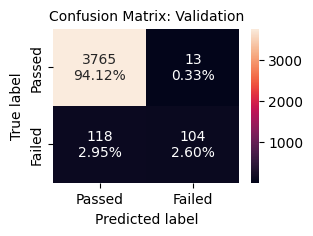

____________________________________________________________________________________________________
Model: Decision Tree
Cross-Validation recall performance on training dataset: 71.52%
Accuracy on training set : 100.00%
Accuracy on validation set : 97.10%
Recall on training set : 100.00%
Recall on validation set : 72.52%
Precision on training set : 100.00%
Precision on validation set : 74.54%
F1 score on training set : 100.00%
F1 score on validation set : 73.52%


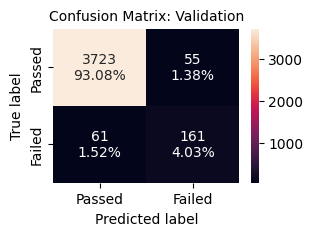

____________________________________________________________________________________________________
Model: Random Forest
Cross-Validation recall performance on training dataset: 71.97%
Accuracy on training set : 100.00%
Accuracy on validation set : 98.58%
Recall on training set : 100.00%
Recall on validation set : 74.32%
Precision on training set : 100.00%
Precision on validation set : 100.00%
F1 score on training set : 100.00%
F1 score on validation set : 85.27%


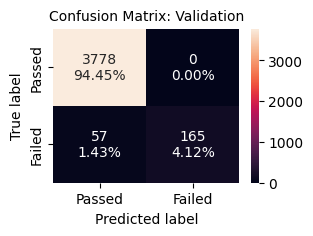

____________________________________________________________________________________________________
Model: Bagging
Cross-Validation recall performance on training dataset: 70.06%
Accuracy on training set : 99.76%
Accuracy on validation set : 98.20%
Recall on training set : 95.72%
Recall on validation set : 70.72%
Precision on training set : 99.88%
Precision on validation set : 95.73%
F1 score on training set : 97.76%
F1 score on validation set : 81.35%


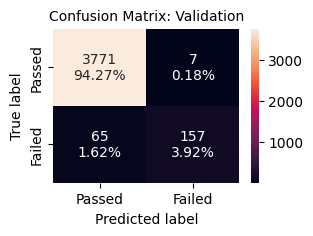

____________________________________________________________________________________________________
Model: Adaboost
Cross-Validation recall performance on training dataset: 60.59%
Accuracy on training set : 97.66%
Accuracy on validation set : 97.67%
Recall on training set : 65.20%
Recall on validation set : 65.32%
Precision on training set : 89.91%
Precision on validation set : 90.06%
F1 score on training set : 75.59%
F1 score on validation set : 75.72%


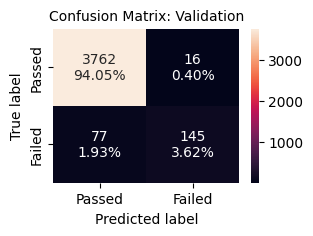

____________________________________________________________________________________________________
Model: Gradient Boosting
Cross-Validation recall performance on training dataset: 70.84%
Accuracy on training set : 98.89%
Accuracy on validation set : 98.15%
Recall on training set : 81.53%
Recall on validation set : 72.07%
Precision on training set : 98.24%
Precision on validation set : 93.02%
F1 score on training set : 89.11%
F1 score on validation set : 81.22%


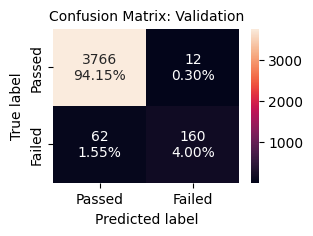

____________________________________________________________________________________________________
Model: Xgboost
Cross-Validation recall performance on training dataset: 80.86%
Accuracy on training set : 100.00%
Accuracy on validation set : 99.02%
Recall on training set : 100.00%
Recall on validation set : 82.88%
Precision on training set : 100.00%
Precision on validation set : 99.46%
F1 score on training set : 100.00%
F1 score on validation set : 90.42%


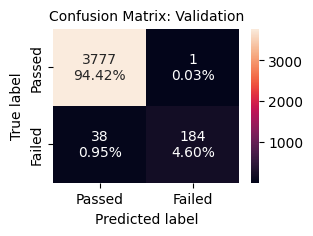

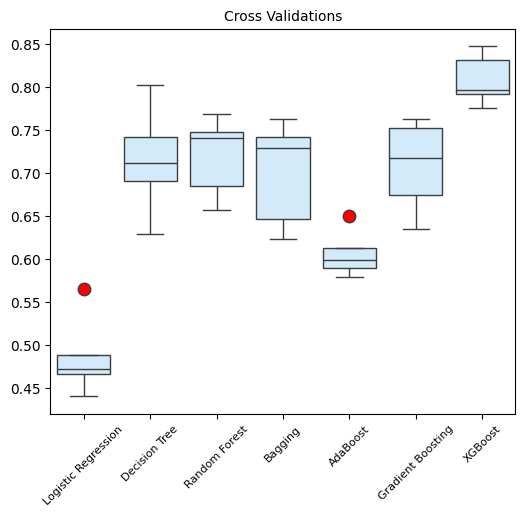

CPU times: total: 53.5 s
Wall time: 3min 37s


In [43]:
%%time

# Create empty list to store all the models
models = []  

# Create a dataframe that will contain the validation scores of the models
model_score_orig = pd.DataFrame(columns = ['Model Name',
                                      'Accuracy Training',     
                                      'Accuracy Validation',
                                      'Recall Training',
                                      'Recall Validation',
                                      'Precision Training',
                                      'Precision Validation',
                                      'F1 Training',
                                      'F1 Validation'])

# Appending models into the list
models.append(("Logistic Regression", LogisticRegression(random_state=1)))
models.append(("Decision Tree", DecisionTreeClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("AdaBoost", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost", XGBClassifier(random_state=1)))

# Create empty list to store CV scores of a model
results1 = []  
names = []

# Setting number of splits equal to 5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  

# loop through all models to get the mean cross validated score
for name, model in models:
    print("_"*100)
    
    # Print the model name running
    print(f"Model: {name.replace('_',' ').title()}")   
    
    # Perform the cross validation of the training data using the recall for scoring
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold, n_jobs=-1)
    results1.append(cv_result)
    names.append(name)
    
    print(f"Cross-Validation recall performance on training dataset: {round(cv_result.mean()*100,2):.2f}%" )
    model.fit(X_train, y_train)
    
    # Get the accuracy, recall, precision, and F1 scores for the model
    score = get_metrics_score(model, X_train, y_train, X_val, y_val, 'validation')
    
    # Append the name of the model to the score list
    score.insert(0,name.replace('_',' ').title())

    # Append the model score list to the original model score dataframe
    model_score_orig.loc[len(model_score_orig)] = score
    
    # Create a confusion matrix of the model validation scores
    create = create_confusion_matrix(model,X_val, y_val, 'Validation')

# Create a boxplot of the CV recall scores
boxplots(results1, names)

#### Observations:
 * XGBoost and decision tree have the highest cross validation scores

In [44]:
# Show the scores for the original models
model_score_orig

Model Name  Accuracy Training  Accuracy Validation  \
0  Logistic Regression           0.966562              0.96725   
1        Decision Tree           1.000000              0.97100   
2        Random Forest           1.000000              0.98575   
3              Bagging           0.997563              0.98200   
4             Adaboost           0.976625              0.97675   
5    Gradient Boosting           0.988938              0.98150   
6              Xgboost           1.000000              0.99025   

   Recall Training  Recall Validation  Precision Training  \
0         0.490991           0.468468            0.840077   
1         1.000000           0.725225            1.000000   
2         1.000000           0.743243            1.000000   
3         0.957207           0.707207            0.998825   
4         0.652027           0.653153            0.899068   
5         0.815315           0.720721            0.982361   
6         1.000000           0.828829            1.000000   

   Precision Validation  F1 Training  F1 Validation  
0              0.888889     0.619758       0.613569  
1              0.745370     1.000000       0.735160  
2              1.000000     1.000000       0.852713  
3              0.957317     0.977573       0.813472  
4              0.900621     0.755875       0.757180  
5              0.930233     0.891077       0.812183  
6              0.994595     1.000000       0.904177

#### Observaations:
 * XGBoost and random forest have the highest recall validation scores

### Model Building with Oversampled data


In [45]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After OverSampling, counts of label '1': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_over == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_over.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label '1': 888
Before OverSampling, counts of label '0': 15112 

After OverSampling, counts of label '1': 15112
After OverSampling, counts of label '0': 15112 

After OverSampling, the shape of train_X: (30224, 40)
After OverSampling, the shape of train_y: (30224,) 



In [46]:
# Print information on the training and validation data sets
print(f'X train rows: {X_train_over.shape[0]}')
print(f'X validation rows: {X_val.shape[0]}')
print(f'Y train rows: {y_train_over.shape[0]}')
print(f'Y validation rows: {y_val.shape[0]}')
print('df target passed pct: {:.2f}%'
     .format(df['Target'].value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('df target failed pct: {:.2f}%'
     .format(df['Target'].value_counts(normalize=True).sort_values(ascending=False)[1]*100))
print('Y train target passed pct: {:.2f}%'
      .format(y_train_over.value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('Y train target passed pct: {:.2f}%'
      .format(y_train_over.value_counts(normalize=True).sort_values(ascending=False)[1]*100))
print('y validation target passed pct: {:.2f}%'
      .format(y_val.value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('y validation target passed pct: {:.2f}%'
      .format(y_val.value_counts(normalize=True).sort_values(ascending=False)[1]*100))

X train rows: 30224
X validation rows: 4000
Y train rows: 30224
Y validation rows: 4000
df target passed pct: 94.45%
df target failed pct: 5.55%
Y train target passed pct: 50.00%
Y train target passed pct: 50.00%
y validation target passed pct: 94.45%
y validation target passed pct: 5.55%


____________________________________________________________________________________________________
Model: Logistic Regression Os
Cross-Validation recall performance on training dataset: 88.21%
Accuracy on training set : 88.03%
Accuracy on validation set : 87.22%
Recall on training set : 88.25%
Recall on validation set : 84.68%
Precision on training set : 87.86%
Precision on validation set : 28.27%
F1 score on training set : 88.06%
F1 score on validation set : 42.39%


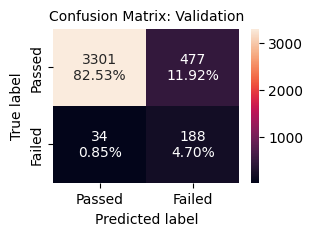

____________________________________________________________________________________________________
Model: Decision Tree Os
Cross-Validation recall performance on training dataset: 97.06%
Accuracy on training set : 100.00%
Accuracy on validation set : 94.75%
Recall on training set : 100.00%
Recall on validation set : 81.08%
Precision on training set : 100.00%
Precision on validation set : 51.72%
F1 score on training set : 100.00%
F1 score on validation set : 63.16%


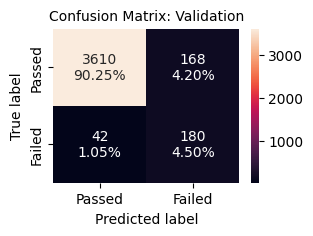

____________________________________________________________________________________________________
Model: Random Forest Os
Cross-Validation recall performance on training dataset: 98.26%
Accuracy on training set : 100.00%
Accuracy on validation set : 98.95%
Recall on training set : 100.00%
Recall on validation set : 84.68%
Precision on training set : 100.00%
Precision on validation set : 95.92%
F1 score on training set : 100.00%
F1 score on validation set : 89.95%


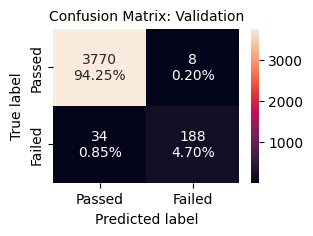

____________________________________________________________________________________________________
Model: Bagging Os
Cross-Validation recall performance on training dataset: 97.76%
Accuracy on training set : 99.95%
Accuracy on validation set : 98.28%
Recall on training set : 99.91%
Recall on validation set : 82.88%
Precision on training set : 99.99%
Precision on validation set : 85.58%
F1 score on training set : 99.95%
F1 score on validation set : 84.21%


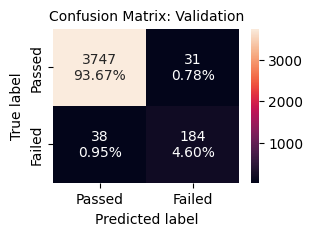

____________________________________________________________________________________________________
Model: Adaboost Os
Cross-Validation recall performance on training dataset: 89.61%
Accuracy on training set : 90.78%
Accuracy on validation set : 90.53%
Recall on training set : 90.07%
Recall on validation set : 86.49%
Precision on training set : 91.37%
Precision on validation set : 35.49%
F1 score on training set : 90.71%
F1 score on validation set : 50.33%


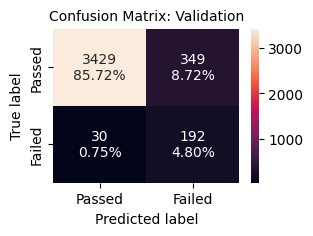

____________________________________________________________________________________________________
Model: Gradient Boosting Os
Cross-Validation recall performance on training dataset: 92.87%
Accuracy on training set : 95.38%
Accuracy on validation set : 96.60%
Recall on training set : 93.18%
Recall on validation set : 89.19%
Precision on training set : 97.48%
Precision on validation set : 63.87%
F1 score on training set : 95.28%
F1 score on validation set : 74.44%


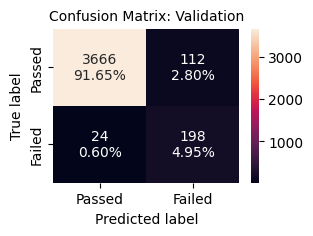

____________________________________________________________________________________________________
Model: Xgboost Os
Cross-Validation recall performance on training dataset: 99.15%
Accuracy on training set : 100.00%
Accuracy on validation set : 98.80%
Recall on training set : 100.00%
Recall on validation set : 87.39%
Precision on training set : 100.00%
Precision on validation set : 90.65%
F1 score on training set : 100.00%
F1 score on validation set : 88.99%


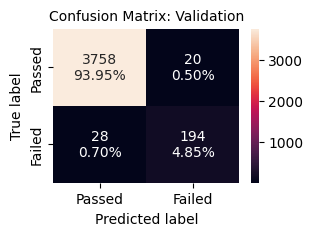

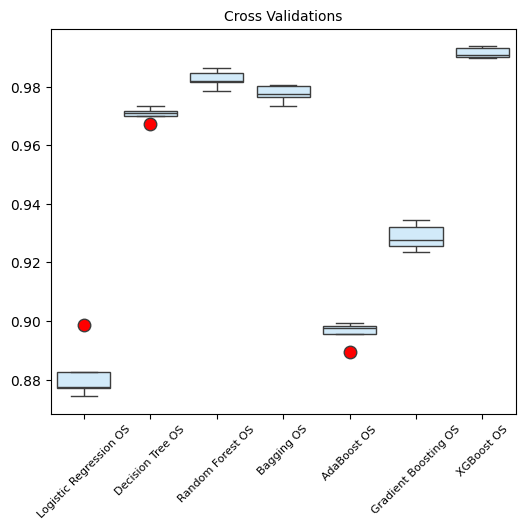

CPU times: total: 1min 32s
Wall time: 5min 16s


In [47]:
%%time

# Create empty list to store all the models
models = [] 

# Create a dataframe that will contain the validation scores of the models
model_score_over = pd.DataFrame(columns = ['Model Name',
                                      'Accuracy Training',     
                                      'Accuracy Validation',
                                      'Recall Training',
                                      'Recall Validation',
                                      'Precision Training',
                                      'Precision Validation',
                                      'F1 Training',
                                      'F1 Validation'])

# Appending models into the list
models.append(("Logistic Regression OS", LogisticRegression(random_state=1)))
models.append(("Decision Tree OS", DecisionTreeClassifier(random_state=1)))
models.append(("Random Forest OS", RandomForestClassifier(random_state=1)))
models.append(("Bagging OS", BaggingClassifier(random_state=1)))
models.append(("AdaBoost OS", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting OS", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost OS", XGBClassifier(random_state=1)))

# Create empty list to store CV scores of a model
results1 = [] 
names = []

# Setting number of splits equal to 5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  

# loop through all models to get the mean cross validated score
for name, model in models:
    print("_"*100)
    
    # Print the model name running
    print(f"Model: {name.replace('_',' ').title()}")   
    
    # Perform the cross validation of the training data using the recall for scoring
    cv_result = cross_val_score(estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold, n_jobs=-1)
    results1.append(cv_result)
    names.append(name)
    
    print(f"Cross-Validation recall performance on training dataset: {round(cv_result.mean()*100,2):.2f}%" )
    model.fit(X_train_over, y_train_over)
    
    # Get the accuracy, recall, precision, and F1 scores for the model
    score = get_metrics_score(model, X_train_over, y_train_over, X_val, y_val, 'validation')
    
    # Append the name of the model to the score list
    score.insert(0,name.replace('_',' ').title())

    # Append the model score list to the oversampled model score dataframe
    model_score_over.loc[len(model_score_over)] = score
        
    # Create a confusion matrix of the model validation scores
    create = create_confusion_matrix(model,X_val, y_val, 'Validation')

# Create a boxplot of the CV recall scores
boxplots(results1, names)    
    

#### Observations:
 * XGBoost, random forest, and bagging have the highest cross validation scores

In [48]:
# Show the scores for the oversampled models
model_score_over

Model Name  Accuracy Training  Accuracy Validation  \
0  Logistic Regression Os           0.880327              0.87225   
1        Decision Tree Os           1.000000              0.94750   
2        Random Forest Os           1.000000              0.98950   
3              Bagging Os           0.999504              0.98275   
4             Adaboost Os           0.907789              0.90525   
5    Gradient Boosting Os           0.953845              0.96600   
6              Xgboost Os           1.000000              0.98800   

   Recall Training  Recall Validation  Precision Training  \
0         0.882544           0.846847            0.878648   
1         1.000000           0.810811            1.000000   
2         1.000000           0.846847            1.000000   
3         0.999140           0.828829            0.999868   
4         0.900675           0.864865            0.913674   
5         0.931776           0.891892            0.974801   
6         1.000000           0.873874            1.000000   

   Precision Validation  F1 Training  F1 Validation  
0              0.282707     0.880592       0.423901  
1              0.517241     1.000000       0.631579  
2              0.959184     1.000000       0.899522  
3              0.855814     0.999504       0.842105  
4              0.354898     0.907128       0.503277  
5              0.638710     0.952803       0.744361  
6              0.906542     1.000000       0.889908

#### Observations:
 * Gradient boosting and XGBoost have the highest recall validation scores 

### Model Building with Undersampled data

In [49]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

print("After OverSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))

print("After OverSampling, the shape of train_X: {}".format(X_train_un.shape))
print("After OverSampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before OverSampling, counts of label '1': 888
Before OverSampling, counts of label '0': 15112 

After OverSampling, counts of label '1': 888
After OverSampling, counts of label '0': 888 

After OverSampling, the shape of train_X: (1776, 40)
After OverSampling, the shape of train_y: (1776,) 



In [50]:
# Print information on the training and validation data sets
print(f'X train rows: {X_train_un.shape[0]}')
print(f'X validation rows: {X_val.shape[0]}')
print(f'Y train rows: {y_train_un.shape[0]}')
print(f'Y validation rows: {y_val.shape[0]}')
print('df target passed pct: {:.2f}%'
     .format(df['Target'].value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('df target failed pct: {:.2f}%'
     .format(df['Target'].value_counts(normalize=True).sort_values(ascending=False)[1]*100))
print('Y train target passed pct: {:.2f}%'
      .format(y_train_un.value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('Y train target passed pct: {:.2f}%'
      .format(y_train_un.value_counts(normalize=True).sort_values(ascending=False)[1]*100))
print('y validation target passed pct: {:.2f}%'
      .format(y_val.value_counts(normalize=True).sort_values(ascending=False)[0]*100))
print('y validation target passed pct: {:.2f}%'
      .format(y_val.value_counts(normalize=True).sort_values(ascending=False)[1]*100))

X train rows: 1776
X validation rows: 4000
Y train rows: 1776
Y validation rows: 4000
df target passed pct: 94.45%
df target failed pct: 5.55%
Y train target passed pct: 50.00%
Y train target passed pct: 50.00%
y validation target passed pct: 94.45%
y validation target passed pct: 5.55%


____________________________________________________________________________________________________
Model: Logistic Regression Us
Cross-Validation recall performance on training dataset: 86.37%
Accuracy on training set : 86.99%
Accuracy on validation set : 85.32%
Recall on training set : 86.60%
Recall on validation set : 86.04%
Precision on training set : 87.29%
Precision on validation set : 25.57%
F1 score on training set : 86.94%
F1 score on validation set : 39.42%


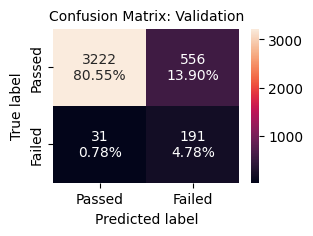

____________________________________________________________________________________________________
Model: Decision Tree Us
Cross-Validation recall performance on training dataset: 85.36%
Accuracy on training set : 100.00%
Accuracy on validation set : 83.62%
Recall on training set : 100.00%
Recall on validation set : 81.08%
Precision on training set : 100.00%
Precision on validation set : 22.70%
F1 score on training set : 100.00%
F1 score on validation set : 35.47%


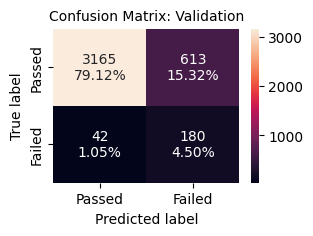

____________________________________________________________________________________________________
Model: Random Forest Us
Cross-Validation recall performance on training dataset: 90.09%
Accuracy on training set : 100.00%
Accuracy on validation set : 94.83%
Recall on training set : 100.00%
Recall on validation set : 88.74%
Precision on training set : 100.00%
Precision on validation set : 51.98%
F1 score on training set : 100.00%
F1 score on validation set : 65.56%


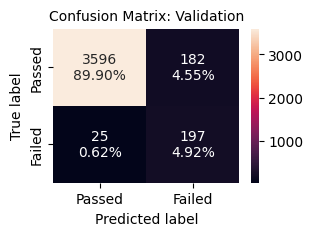

____________________________________________________________________________________________________
Model: Bagging Us
Cross-Validation recall performance on training dataset: 88.63%
Accuracy on training set : 98.54%
Accuracy on validation set : 93.73%
Recall on training set : 97.18%
Recall on validation set : 85.59%
Precision on training set : 99.88%
Precision on validation set : 46.45%
F1 score on training set : 98.52%
F1 score on validation set : 60.22%


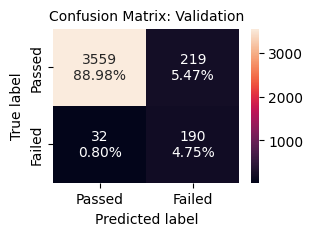

____________________________________________________________________________________________________
Model: Adaboost Us
Cross-Validation recall performance on training dataset: 85.92%
Accuracy on training set : 91.05%
Accuracy on validation set : 87.95%
Recall on training set : 89.30%
Recall on validation set : 86.04%
Precision on training set : 92.53%
Precision on validation set : 29.75%
F1 score on training set : 90.89%
F1 score on validation set : 44.21%


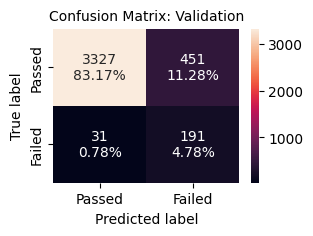

____________________________________________________________________________________________________
Model: Gradient Boosting Us
Cross-Validation recall performance on training dataset: 89.08%
Accuracy on training set : 95.95%
Accuracy on validation set : 93.10%
Recall on training set : 93.69%
Recall on validation set : 89.19%
Precision on training set : 98.11%
Precision on validation set : 44.00%
F1 score on training set : 95.85%
F1 score on validation set : 58.93%


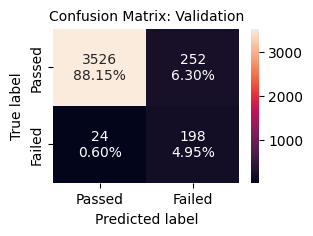

____________________________________________________________________________________________________
Model: Xgboost Us
Cross-Validation recall performance on training dataset: 89.97%
Accuracy on training set : 100.00%
Accuracy on validation set : 95.28%
Recall on training set : 100.00%
Recall on validation set : 89.64%
Precision on training set : 100.00%
Precision on validation set : 54.52%
F1 score on training set : 100.00%
F1 score on validation set : 67.80%


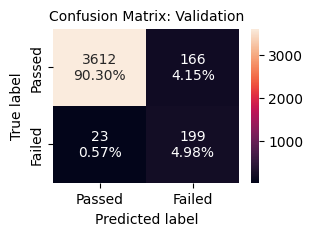

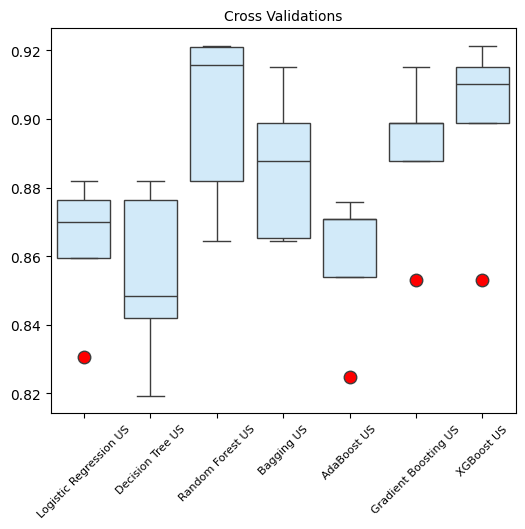

CPU times: total: 6.92 s
Wall time: 19.6 s


In [51]:
%%time

# Create empty list to store all the models
models = [] 

# Create a dataframe that will contain the validation scores of the models
model_score_under = pd.DataFrame(columns = ['Model Name',
                                      'Accuracy Training',     
                                      'Accuracy Validation',
                                      'Recall Training',
                                      'Recall Validation',
                                      'Precision Training',
                                      'Precision Validation',
                                      'F1 Training',
                                      'F1 Validation'])

# Appending models into the list
models.append(("Logistic Regression US", LogisticRegression(random_state=1)))
models.append(("Decision Tree US", DecisionTreeClassifier(random_state=1)))
models.append(("Random Forest US", RandomForestClassifier(random_state=1)))
models.append(("Bagging US", BaggingClassifier(random_state=1)))
models.append(("AdaBoost US", AdaBoostClassifier(random_state=1)))
models.append(("Gradient Boosting US", GradientBoostingClassifier(random_state=1)))
models.append(("XGBoost US", XGBClassifier(random_state=1)))

# Create empty list to store CV scores of a model
results1 = [] 
names=[]
                                 
# Setting number of splits equal to 5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)  

# loop through all models to get the mean cross validated score
for name, model in models:
    print("_"*100)
    
    # Print the model name running
    print(f"Model: {name.replace('_',' ').title()}")   
    
    # Perform the cross validation of the training data using the recall for scoring
    cv_result = cross_val_score(estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold, n_jobs=-1)
    results1.append(cv_result)
    names.append(name)

    print(f"Cross-Validation recall performance on training dataset: {round(cv_result.mean()*100,2):.2f}%" )
    model.fit(X_train_un, y_train_un)
    
    # Get the accuracy, recall, precision, and F1 scores for the model
    score = get_metrics_score(model, X_train_un, y_train_un, X_val, y_val, 'validation')
    
    # Append the name of the model to the score list
    score.insert(0,name.replace('_',' ').title())

    # Append the model score list to the undersampled score dataframe
    model_score_under.loc[len(model_score_under)] = score
    
    # Create a confusion matrix of the model validation scores
    create = create_confusion_matrix(model,X_val, y_val, 'Validation')

# Create a boxplot of the CV recall scores
boxplots(results1, names)                                  
                                 

#### Observations:
 * Random Forest and XGBoost have highest cross validation scores

In [52]:
# Show the scores for the undersampled models
model_score_under

Model Name  Accuracy Training  Accuracy Validation  \
0  Logistic Regression Us           0.869932              0.85325   
1        Decision Tree Us           1.000000              0.83625   
2        Random Forest Us           1.000000              0.94825   
3              Bagging Us           0.985360              0.93725   
4             Adaboost Us           0.910473              0.87950   
5    Gradient Boosting Us           0.959459              0.93100   
6              Xgboost Us           1.000000              0.95275   

   Recall Training  Recall Validation  Precision Training  \
0         0.865991           0.860360            0.872872   
1         1.000000           0.810811            1.000000   
2         1.000000           0.887387            1.000000   
3         0.971847           0.855856            0.998843   
4         0.893018           0.860360            0.925321   
5         0.936937           0.891892            0.981132   
6         1.000000           0.896396            1.000000   

   Precision Validation  F1 Training  F1 Validation  
0              0.255689     0.869418       0.394221  
1              0.226986     1.000000       0.354680  
2              0.519789     1.000000       0.655574  
3              0.464548     0.985160       0.602219  
4              0.297508     0.908883       0.442130  
5              0.440000     0.958525       0.589286  
6              0.545205     1.000000       0.678024

#### Observations:
 * XGBoost and gradient boosting have the highest recall validation scores

In [53]:
# Concatenate the three model using the original data, the oversampled data, and the undersampled data
model_scores = pd.concat([model_score_orig, model_score_over, model_score_under]).reset_index(drop=True)

# Show the scores for all models
model_scores

Model Name  Accuracy Training  Accuracy Validation  \
0      Logistic Regression           0.966562              0.96725   
1            Decision Tree           1.000000              0.97100   
2            Random Forest           1.000000              0.98575   
3                  Bagging           0.997563              0.98200   
4                 Adaboost           0.976625              0.97675   
5        Gradient Boosting           0.988938              0.98150   
6                  Xgboost           1.000000              0.99025   
7   Logistic Regression Os           0.880327              0.87225   
8         Decision Tree Os           1.000000              0.94750   
9         Random Forest Os           1.000000              0.98950   
10              Bagging Os           0.999504              0.98275   
11             Adaboost Os           0.907789              0.90525   
12    Gradient Boosting Os           0.953845              0.96600   
13              Xgboost Os           1.000000              0.98800   
14  Logistic Regression Us           0.869932              0.85325   
15        Decision Tree Us           1.000000              0.83625   
16        Random Forest Us           1.000000              0.94825   
17              Bagging Us           0.985360              0.93725   
18             Adaboost Us           0.910473              0.87950   
19    Gradient Boosting Us           0.959459              0.93100   
20              Xgboost Us           1.000000              0.95275   

    Recall Training  Recall Validation  Precision Training  \
0          0.490991           0.468468            0.840077   
1          1.000000           0.725225            1.000000   
2          1.000000           0.743243            1.000000   
3          0.957207           0.707207            0.998825   
4          0.652027           0.653153            0.899068   
5          0.815315           0.720721            0.982361   
6          1.000000           0.828829            1.000000   
7          0.882544           0.846847            0.878648   
8          1.000000           0.810811            1.000000   
9          1.000000           0.846847            1.000000   
10         0.999140           0.828829            0.999868   
11         0.900675           0.864865            0.913674   
12         0.931776           0.891892            0.974801   
13         1.000000           0.873874            1.000000   
14         0.865991           0.860360            0.872872   
15         1.000000           0.810811            1.000000   
16         1.000000           0.887387            1.000000   
17         0.971847           0.855856            0.998843   
18         0.893018           0.860360            0.925321   
19         0.936937           0.891892            0.981132   
20         1.000000           0.896396            1.000000   

    Precision Validation  F1 Training  F1 Validation  
0               0.888889     0.619758       0.613569  
1               0.745370     1.000000       0.735160  
2               1.000000     1.000000       0.852713  
3               0.957317     0.977573       0.813472  
4               0.900621     0.755875       0.757180  
5               0.930233     0.891077       0.812183  
6               0.994595     1.000000       0.904177  
7               0.282707     0.880592       0.423901  
8               0.517241     1.000000       0.631579  
9               0.959184     1.000000       0.899522  
10              0.855814     0.999504       0.842105  
11              0.354898     0.907128       0.503277  
12              0.638710     0.952803       0.744361  
13              0.906542     1.000000       0.889908  
14              0.255689     0.869418       0.394221  
15              0.226986     1.000000       0.354680  
16              0.519789     1.000000       0.655574  
17              0.464548     0.985160       0.602219  
18              0.297508     0.908883       0.442130  
19        

#### Observations:
 * The recall value is the main determinant for deciding which models to perform hyperparameter tuning
 * The over and under sampling models were an improvement over the recall values for the original models
 * Precision and F1 score were much worse with the under sampling models vs the scores for the original models
 * Models that will go through hyperparameter due to high recal scores:
      - Random Forest: Recall is 74%, Precision is 100% and F1 is 85%
      - XGBoost Classifier: Recall is 83%, Precision is 99% and F1 is 90%
      - Random Forest Oversampling: Recall is 85%, Precision is 96% and F1 is 90%
      - Gradient Boosting Classifier Oversampling: Recall is 89%, Precision is 64% and F1 is 74%
      - XGBoost Classifier Oversampling: Recall is 87%, Precision is 91% and F1 is 89%
      - XGBoost Classifier Undersampling: Recall is 90%, Precision is 55% and F1 is 68%
 * The Bagging Oversampling model will also go through tuning due to a high cross validation score of ~98%

## HyperparameterTuning

In [54]:
model_score_tuning = []

# Create a dataframe that will contain the validation scores of the models
model_score_tuning = pd.DataFrame(columns = ['Model Name',
                                      'Accuracy Training',       
                                      'Accuracy Validation',
                                      'Recall Training',       
                                      'Recall Validation',
                                      'Precision Training',       
                                      'Precision Validation',
                                      'F1 Training',       
                                      'F1 Validation'])

In [55]:
# For rerunning tuning models
def DeleteModelRows(df, Model_Name):
    if df[df['Model Name'] == Model_Name].empty == False:
        df = df.drop(df[df['Model Name'] == Model_Name].index, inplace=True)

In [56]:
def ModelBuilding(Model, parameters, model_name,X_data, y_data, x_test_data, y_test_data, test_name):
    
    # Setting number of splits equal to 5
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) 
    
    #Calling RandomizedSearchCV
    model = RandomizedSearchCV(estimator=Model, param_distributions=parameters, 
                                   n_iter=20, n_jobs = -1, scoring=scorer, cv=kfold, random_state=1,
                                   refit=True)
    
    #Fitting parameters in RandomizedSearchCV
    model.fit(X_data, y_data)
    
    print("Best parameters are {} \n with CV score={}:" .format(model.best_params_,model.best_score_))
    print('\n')
    
    # Set the clf to the best combination of parameters
    random_tuned = model.best_estimator_

    # Fit the best algorithm to the data.
    random_tuned.fit(X_data, y_data)
    
    # Initialize the score list
    score = []
    
    # Get the accuracy, recall, precision, and F1 scores for the model
    score = get_metrics_score(random_tuned, X_data, y_data, x_test_data, y_test_data, test_name)
    
    # Append the name of the model to the score list
    score.insert(0,model_name)
    
    print('\n')
    
    # Create a confusion matrix of the model validation scores
    create_confusion_matrix(random_tuned, x_test_data, y_test_data, test_name)
    
    return score, random_tuned

### Random Forest Classifier: Tuning

Best parameters are {'n_estimators': 325, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 6, 'max_depth': 5, 'class_weight': 'balanced'} 
 with CV score=0.8468418713895766:


Accuracy on training set : 95.80%
Accuracy on Validation set : 95.58%
Recall on training set : 89.30%
Recall on Validation set : 84.23%
Precision on training set : 57.88%
Precision on Validation set : 56.84%
F1 score on training set : 70.24%
F1 score on Validation set : 67.88%




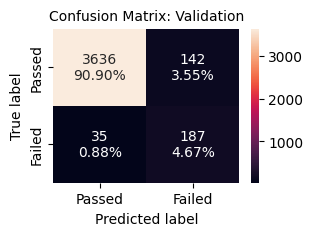

CPU times: total: 27.9 s
Wall time: 1min 2s


In [57]:
%%time

# Build the random forest model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
parameters = {"n_estimators": [325],
              "min_samples_leaf": [7],
              "max_features": [6],
              "class_weight": ['balanced'],
              "min_samples_split":[4],
              "max_depth":[5]         
             }

model_name = 'Random Forest'

# Delete the row from the model scoring dataset
DeleteModelRows(model_score_tuning, model_name)

# Run the ModelBuilding function to create the model, retrieve performance scores, and create a confusion matrix
score, RF_Tuned_Model = ModelBuilding(Model, parameters, model_name, X_train, y_train, X_val, y_val, 'Validation')

# Append the model score list to the undersampled model score dataframe
model_score_tuning.loc[len(model_score_tuning)] = score

### XGBoost Classifier: Tuning

Best parameters are {'subsample': 0.55, 'scale_pos_weight': 90, 'n_estimators': 300, 'learning_rate': 0.015, 'gamma': 7} 
 with CV score=0.8964070335809051:


Accuracy on training set : 96.24%
Accuracy on Validation set : 95.05%
Recall on training set : 100.00%
Recall on Validation set : 91.44%
Precision on training set : 59.60%
Precision on Validation set : 53.14%
F1 score on training set : 74.68%
F1 score on Validation set : 67.22%




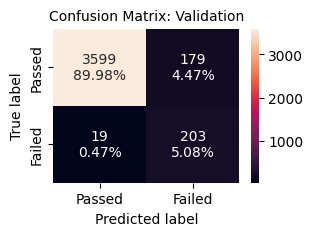

CPU times: total: 14.5 s
Wall time: 17.6 s


In [58]:
%%time

# Build the xgboost model 
Model = XGBClassifier(random_state=1,eval_metric='logloss')

# Add the grid parameters
# The ranges were mostly removed to speed up reprocessing times 
parameters = {'n_estimators': [300],
              'learning_rate': [0.015],
              'gamma': [7],
              'subsample': np.arange(0.45,0.56,0.1),   
              'scale_pos_weight': [90]
}

model_name = 'XGBoost Classifier'

# Delete the row from the model scoring dataset
DeleteModelRows(model_score_tuning, model_name)

# Run the ModelBuilding function to create the model, retrieve performance scores, and create a confusion matrix
score, XGB_Tuned_Model = ModelBuilding(Model, parameters, model_name, X_train, y_train, X_val, y_val, 'Validation')

# Append the model score list to the undersampled model score dataframe
model_score_tuning.loc[len(model_score_tuning)] = score

### Random Forest Classifier: Oversampling Tuning

Best parameters are {'n_estimators': 225, 'min_samples_leaf': 1, 'max_features': 7, 'max_depth': 12, 'criterion': 'entropy'} 
 with CV score=0.9598994297633869:


Accuracy on training set : 98.78%
Accuracy on Validation set : 99.00%
Recall on training set : 97.60%
Recall on Validation set : 86.04%
Precision on training set : 99.95%
Precision on Validation set : 95.50%
F1 score on training set : 98.76%
F1 score on Validation set : 90.52%




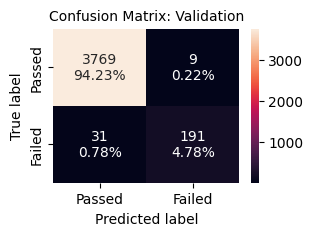

CPU times: total: 1min 47s
Wall time: 5min 7s


In [59]:
%%time

# Build the random forest model
Model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
parameters = {"n_estimators": [225],
              "min_samples_leaf": [1],
              "max_features": [7],
              "max_depth":np.arange(11,13,1),
              "criterion":['entropy']
             
             }

model_name = 'Random Forest OS'

# Delete the row from the model scoring dataset
DeleteModelRows(model_score_tuning, model_name)

# Run the ModelBuilding function to create the model, retrieve performance scores, and create a confusion matrix
score, RFC_OS_Tuned_Model = ModelBuilding(Model, parameters, model_name, 
                                          X_train_over, y_train_over, X_val, y_val, 'Validation')

# Append the model score list to the undersampled model score dataframe
model_score_tuning.loc[len(model_score_tuning)] = score

### Bagging Classifier: Oversampling Tuning

Best parameters are {'n_estimators': 100, 'max_samples': 0.4, 'max_features': 0.5, 'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=6, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'bootstrap': True} 
 with CV score=0.9350845590818944:


Accuracy on training set : 96.47%
Accuracy on Validation set : 98.02%
Recall on training set

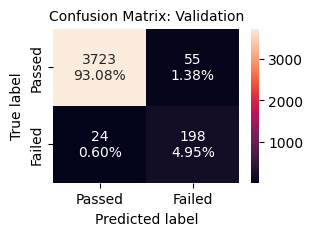

CPU times: total: 4min
Wall time: 3min 31s


In [60]:
%%time

# Build the bagging model
Model = BaggingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
parameters = { 'max_samples': [0.4], 
               'max_features': [0.5], 
               'n_estimators' : [100],
               'bootstrap': [True],
               'estimator': [XGBClassifier(subsample=0.45, 
                                           learning_rate=0.1,
                                           gamma=6
                                          )]             
             }

model_name = 'Bagging OS'

# Delete the row from the model scoring dataset
DeleteModelRows(model_score_tuning, model_name)

# Run the ModelBuilding function to create the model, retrieve performance scores, and create a confusion matrix
score, Bagging_OS_Tuned_Model = ModelBuilding(Model, parameters, model_name, 
                                              X_train_over, y_train_over, X_val, y_val, 'Validation')

# Append the model score list to the undersampled model score dataframe
model_score_tuning.loc[len(model_score_tuning)] = score

### Gradient Boosting Classifier: Oversampling Tuning

Best parameters are {'subsample': 0.7, 'n_estimators': 200, 'max_features': 5, 'max_depth': 4} 
 with CV score=0.9535467438804156:


Accuracy on training set : 97.85%
Accuracy on Validation set : 98.08%
Recall on training set : 96.52%
Recall on Validation set : 89.64%
Precision on training set : 99.16%
Precision on Validation set : 78.66%
F1 score on training set : 97.82%
F1 score on Validation set : 83.79%




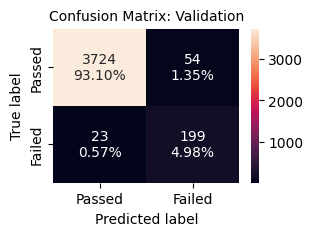

CPU times: total: 24.4 s
Wall time: 53.2 s


In [61]:
%%time

# Build the gradient boosting model
Model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
parameters = {"n_estimators": [200],
              "subsample": [0.7],
              "max_features":[5],
              "max_depth": [4]
              }


model_name = 'Gradient Boosting OS'

# Delete the row from the model scoring dataset
DeleteModelRows(model_score_tuning, model_name)

# Run the ModelBuilding function to create the model, retrieve performance scores, and create a confusion matrix
score, GBC_OS_Tuned_Model = ModelBuilding(Model, parameters, model_name, X_train_over, y_train_over, X_val, y_val, 'Validation')

# Append the model score list to the undersampled model score dataframe
model_score_tuning.loc[len(model_score_tuning)] = score


### XGBoost Classifier: Oversampling Tuning

Best parameters are {'subsample': 0.45, 'n_estimators': 250, 'learning_rate': 0.1, 'gamma': 6} 
 with CV score=0.9970884809226769:


Accuracy on training set : 99.18%
Accuracy on Validation set : 96.58%
Recall on training set : 100.00%
Recall on Validation set : 90.99%
Precision on training set : 98.38%
Precision on Validation set : 63.32%
F1 score on training set : 99.18%
F1 score on Validation set : 74.68%




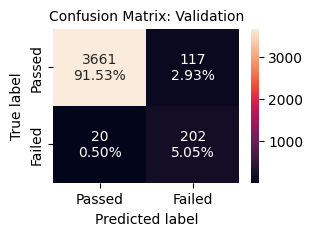

CPU times: total: 10.9 s
Wall time: 9.35 s


In [62]:
%%time

# Calculate the parameter value for the classifier
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


# Build the xgboost model 
Model = XGBClassifier(random_state=1,eval_metric='logloss', scale_pos_weight = scale_pos_weight)

# Add the grid parameters
# The ranges were mostly removed to speed up reprocessing times 
parameters = {'n_estimators': [250],
     'learning_rate': [0.1],
     'gamma': [6],
     'subsample': [0.45]
}

model_name = 'XGBoost OS'

# Delete the row from the model scoring dataset
DeleteModelRows(model_score_tuning, model_name)

# Run the ModelBuilding function to create the model, retrieve performance scores, and create a confusion matrix
score, XGB_OS_Tuned_Model = ModelBuilding(Model, parameters, model_name, X_train_over, y_train_over, X_val, y_val, 'Validation')

# Append the model score list to the undersampled model score dataframe
model_score_tuning.loc[len(model_score_tuning)] = score


### XGBoost Classifier: Undersampling Tuning

Best parameters are {'subsample': 0.9, 'n_estimators': 100, 'learning_rate': 0.4, 'gamma': 11} 
 with CV score=0.9211578746905353:


Accuracy on training set : 92.00%
Accuracy on Validation set : 71.58%
Recall on training set : 100.00%
Recall on Validation set : 93.24%
Precision on training set : 86.21%
Precision on Validation set : 15.58%
F1 score on training set : 92.60%
F1 score on Validation set : 26.69%




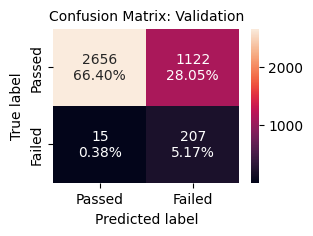

CPU times: total: 1.05 s
Wall time: 832 ms


In [63]:
%%time

# Calculate the parameter value for the classifier
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Build the xgboost model 
Model = XGBClassifier(random_state=1, scale_pos_weight = scale_pos_weight) 

# Add the grid parameters
# The ranges were mostly removed to speed up reprocessing times 
parameters = {'n_estimators': [100],
     'learning_rate': [0.4],
     'gamma': [11],
     'subsample': [0.9]
}

model_name = 'XGBoost US'

# Delete the row from the model scoring dataset
DeleteModelRows(model_score_tuning, model_name)

# Run the ModelBuilding function to create the model, retrieve performance scores, and create a confusion matrix
score, XGB_US_Tuned_Model = ModelBuilding(Model, parameters, model_name, X_train_un, y_train_un, X_val, y_val, 'Validation')

# Append the model score list to the undersampled model score dataframe
model_score_tuning.loc[len(model_score_tuning)] = score


## Model performance comparison and choosing the final model

In [64]:
model_score_tuning

Model Name  Accuracy Training  Accuracy Validation  \
0         Random Forest           0.958000              0.95575   
1    XGBoost Classifier           0.962375              0.95050   
2      Random Forest OS           0.987791              0.99000   
3            Bagging OS           0.964664              0.98025   
4  Gradient Boosting OS           0.978494              0.98075   
5            XGBoost OS           0.991762              0.96575   
6            XGBoost US           0.920045              0.71575   

   Recall Training  Recall Validation  Precision Training  \
0         0.893018           0.842342            0.578832   
1         1.000000           0.914414            0.595973   
2         0.976046           0.860360            0.999526   
3         0.940709           0.891892            0.988046   
4         0.965193           0.896396            0.991570   
5         1.000000           0.909910            0.983790   
6         1.000000           0.932432            0.862136   

   Precision Validation  F1 Training  F1 Validation  
0              0.568389     0.702391       0.678766  
1              0.531414     0.746846       0.672185  
2              0.955000     0.987646       0.905213  
3              0.782609     0.963797       0.833684  
4              0.786561     0.978204       0.837895  
5              0.633229     0.991829       0.746765  
6              0.155756     0.925965       0.266925

Models Performing Well With The Validation Data


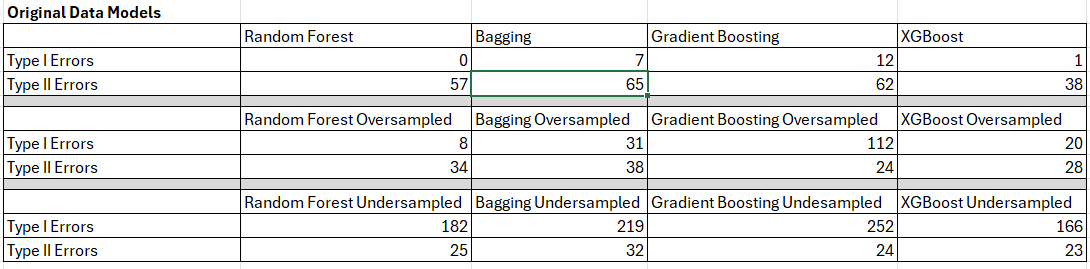

In [65]:
from IPython.display import Image

print('Models Performing Well With The Validation Data')
Image("Screenshot_TypeErrors_NonTuning.png")


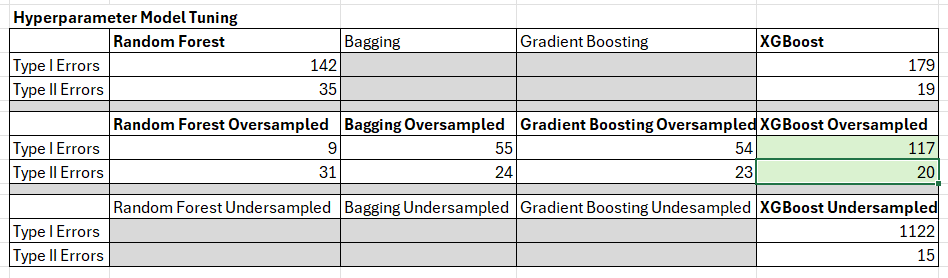

In [66]:
Image("Screenshot_TypeErrors_Tuning.png")

### Test set final performance

 * The XGBoost tuned model with oversampling data will be used for testing and final performance evaluation. The model had 91% recall score. Based on the validation set, the number of false negative errors (Type II) predicted were 20 and the number of false positive errors (Type I) were 117

#### Test the XGBooosting Oversampled Tuned Model

Accuracy on training set : 98.44%
Accuracy on testing set : 96.30%
Recall on training set : 100.00%
Recall on testing set : 86.17%
Precision on training set : 78.10%
Precision on testing set : 62.47%
F1 score on training set : 87.70%
F1 score on testing set : 72.43%


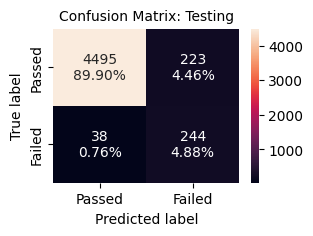

In [67]:
# Test the XGBooosting Oversampled Tuned Model
get_metrics_score(XGB_OS_Tuned_Model, X_train, y_train, X_test, y_test, 'testing')
create_confusion_matrix(XGB_Tuned_Model,X_test, y_test, 'Testing')

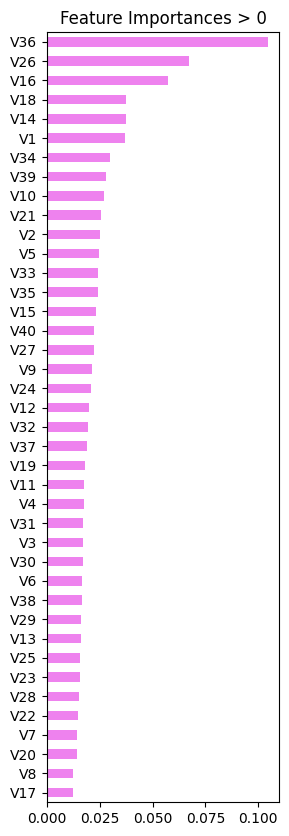

In [68]:
# Plot the Gini importance features that are greater than 0
df_imp = pd.Series(XGB_OS_Tuned_Model.feature_importances_, index=X_train.columns)
df_imp = df_imp[df_imp>0].sort_values(ascending=True)
plt.figure(figsize=(3,10))
plt.title('Feature Importances > 0')
plt.xlabel('Relative Importance')
df_imp.plot(kind='barh',color='violet', align='center')
plt.show()

#### Observations:
 * The most importance features of the XGBoost model are V36, V26, V16, V18, V14, and V1

## Pipelines to build the final model

In [69]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31',
       'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40',
       'Target'],
      dtype='object')

In [70]:
# Create copy of the training set
df_copy2 = df.copy()

# Create copy of the testing set
df_test_copy2 = df_test.copy()

# Split the training data into the independent feature variables (X1) and target variable (Y1)
X1 = df_copy2.drop(['Target'], axis=1)
Y1 = df_copy2['Target']

# Split the testing data into the independent feature variables (X1_test) and target variable (Y1_test)
X1_test = df_test_copy2.drop(['Target'], axis=1)
Y1_test = df_test_copy2['Target']

In [71]:
# Calculate the parameter value for the classifier
scale_pos_weight = len(Y1[Y1 == 0]) / len(Y1[Y1 == 1])


# Create the steps to be used in the pipeline
imputer = SimpleImputer(strategy='median', fill_value='numerical')
smote = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
model =  XGBClassifier(random_state=1, 
                       scale_pos_weight = scale_pos_weight, 
                       n_estimators = 100,
                       learning_rate = 0.4,
                       gamma = 11,
                       subsample = 0.9)

# Create the pipeline
pipeline_train = Pipeline(
    steps = [
        ("imputer", imputer),
        ("smote" , smote),
        ("XGBoost", model)
        ]
    )



In [72]:
# Fit the pipeline to the training data
pipeline_train.fit(X1, Y1)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='numerical', strategy='median')),
                ('smote', SMOTE(random_state=1, sampling_strategy=1)),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=11, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.4,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [73]:
# Fit the training missing data 
X1_test = pd.DataFrame(imputer.transform(X1_test), columns=X1_test.columns)

Accuracy on training set : 97.24%
Accuracy on testing set : 94.68%
Recall on training set : 100.00%
Recall on testing set : 85.82%
Precision on training set : 66.79%
Precision on testing set : 51.71%
F1 score on training set : 80.09%
F1 score on testing set : 64.53%




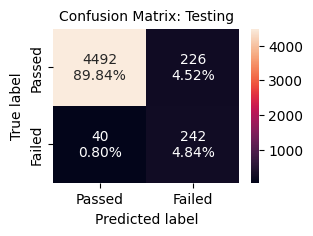

In [74]:
# Calculate the training and test metrics for the model  
get_metrics_score(pipeline_train, X1, Y1, X1_test, Y1_test, 'testing')
    
print('\n')
    
# Create a confusion matrix of the model validation scores
create_confusion_matrix(pipeline_train, X1_test, Y1_test, 'Testing')

# Business Insights and Conclusions

#### Best model and its performance:
 * The best model used was the XGBoost model that was tuned and fit with oversampling data
 * The model had a recall score of 85.82%
 * The model correctly predicted 242 failures that will result in repair costs
 * The model incurred 40 false negatives (FN) that will result in replacement costs. False negatives are when the model predicted no failure and there was a failure of the generator.
 * The model incurred 226 false positives (FP) that will result in inspection costs. False positives are when the model predicted failure and there was no failure of the generator
 * The goal was to ensure the maximum number of generator failures are predicted correctly while minimizing the number of FN and FP errors 
 
#### The model important features:
 * The most importance features of the XGBoost tuned model with oversampled data are V36, V26, V16, V18, V14, and V1
  
#### Additional points:
 * All predicted errors are expected to cause the generator to be inspected
 * Knowing the estimated cost of failure, cost of repair, and cost of inspection would be helpful when determining a balance between recall and precision rates 
 * For the samples that failed but were predicted to not fail, an investigation should be conducted to try and determine if more sensors may be required or if any sensors were malfunctioning
 * Undersampling without tuning caused a decrease in FN errors but a very high increase in FP errors
 * Oversampling without tuning caused a decrease in FN errors and an increase in FP errors
 * During validation testing, when models were tuned to such an extent that the FN errors decreased below ~34, the FP errors started to increase at a much higher rate than the decrease in FN. This indicates there may be a cost-benefit trade-off at some point between the replacement costs of false negatives and the inspection costs of false positives
 * Logistic Regression, Decision Tree and AdaBoost performed poorly in the standard, oversampling, and
   undersampling model builds 
 * There were missing data points in the V1 and V2 attributes that should be investigated as to the reason
 * V1, V18 skewed slightly to the right
 * V30 skewed slightly to the left
 * Columns that have a higher mean statistic for failures vs non-failures: 
     - V1, V4, V7, V8, V11, V14, V15, V16, V17, V20, V21, V23, V28, V29, V34
 * Columns that have a lower mean statistic for failures vs non-failures: 
     - V3, V5, V10, V13, V18, V22, V24, V26, V31, V32, V33, V35, V36, V39
 * Columns that have similar means for failures vs non-failures:
     - V2, V6, V9, V12, V19, V25, V27, V30, V37, V38, V40 
  

***